In [4]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import pandas as pd 
import random
import math
import time

from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime
import operator 
plt.style.use('fivethirtyeight')
%matplotlib inline 

Import the data (make sure you update this on a daily basis)

In [5]:
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recoveries_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
latest_data = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/04-25-2020.csv')
us_medical_data = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports_us/04-25-2020.csv')

In [38]:
latest_data.head()

,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key
0,45001.0,Abbeville,South Carolina,US,2020-04-26 02:30:51,34.223334,-82.461707,24,0,0,24,"Abbeville, South Carolina, US"
1,22001.0,Acadia,Louisiana,US,2020-04-26 02:30:51,30.295065,-92.414197,130,7,0,123,"Acadia, Louisiana, US"
2,51001.0,Accomack,Virginia,US,2020-04-26 02:30:51,37.767072,-75.632346,146,3,0,143,"Accomack, Virginia, US"
3,16001.0,Ada,Idaho,US,2020-04-26 02:30:51,43.452658,-116.241552,650,15,0,635,"Ada, Idaho, US"
4,19001.0,Adair,Iowa,US,2020-04-26 02:30:51,41.330756,-94.471059,1,0,0,1,"Adair, Iowa, US"


In [39]:
confirmed_df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,8/22/20,8/23/20,8/24/20,8/25/20,8/26/20,8/27/20,8/28/20,8/29/20,8/30/20,8/31/20
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,37953,37999,38054,38070,38113,38129,38140,38143,38162,38165
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,8275,8427,8605,8759,8927,9083,9195,9279,9380,9513
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,41068,41460,41858,42228,42619,43016,43403,43781,44146,44494
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,1045,1045,1060,1060,1098,1098,1124,1124,1124,1176
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,2134,2171,2222,2283,2332,2415,2471,2551,2624,2654


In [8]:
us_medical_data.head()

,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,FIPS,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,UID,ISO3,Testing_Rate,Hospitalization_Rate
0,Alabama,US,2020-04-26 02:32:45,32.3182,-86.9023,6026,209,NaN,5817.0,1.0,128.516365,71344.0,839.0,3.468304,84000001,USA,1521.551870,13.923000
1,Alaska,US,2020-04-26 02:32:45,61.3707,-152.4044,339,9,217.0,330.0,2.0,56.712767,15732.0,32.0,2.654867,84000002,USA,2631.873914,9.439528
2,American Samoa,US,2020-04-26 02:32:45,-14.2710,-170.1320,0,0,NaN,NaN,60.0,0.000000,3.0,NaN,NaN,16,ASM,5.391708,NaN
3,Arizona,US,2020-04-26 02:32:45,33.7298,-111.4312,6286,273,1345.0,6013.0,4.0,86.361374,62508.0,1022.0,4.342984,84000004,USA,858.777721,16.258352
4,Arkansas,US,2020-04-26 02:32:45,34.9697,-92.3731,2911,48,964.0,2863.0,5.0,112.436062,38053.0,291.0,1.648918,84000005,USA,1469.779960,9.996565


In [9]:
cols = confirmed_df.keys()


Get all the dates for the outbreak

In [10]:
confirmed = confirmed_df.loc[:, cols[4]:cols[-1]]
deaths = deaths_df.loc[:, cols[4]:cols[-1]]
recoveries = recoveries_df.loc[:, cols[4]:cols[-1]]

In [11]:
dates = confirmed.keys()
world_cases = []
total_deaths = [] 
mortality_rate = []
recovery_rate = [] 
total_recovered = [] 
total_active = [] 

china_cases = [] 
italy_cases = []
us_cases = [] 
spain_cases = [] 
france_cases = [] 
germany_cases = [] 
uk_cases = [] 
russia_cases = [] 

china_deaths = [] 
italy_deaths = []
us_deaths = [] 
spain_deaths = [] 
france_deaths = [] 
germany_deaths = [] 
uk_deaths = [] 
russia_deaths = []

china_recoveries = [] 
italy_recoveries = []
us_recoveries = [] 
spain_recoveries = [] 
france_recoveries = [] 
germany_recoveries = [] 
uk_recoveries = [] 
russia_recoveries = [] 

for i in dates:
    confirmed_sum = confirmed[i].sum()
    death_sum = deaths[i].sum()
    recovered_sum = recoveries[i].sum()
    
    # confirmed, deaths, recovered, and active
    world_cases.append(confirmed_sum)
    total_deaths.append(death_sum)
    total_recovered.append(recovered_sum)
    total_active.append(confirmed_sum-death_sum-recovered_sum)
    
    # calculate rates
    mortality_rate.append(death_sum/confirmed_sum)
    recovery_rate.append(recovered_sum/confirmed_sum)

    # case studies 
    china_cases.append(confirmed_df[confirmed_df['Country/Region']=='China'][i].sum())
    italy_cases.append(confirmed_df[confirmed_df['Country/Region']=='Italy'][i].sum())
    us_cases.append(confirmed_df[confirmed_df['Country/Region']=='US'][i].sum())
    spain_cases.append(confirmed_df[confirmed_df['Country/Region']=='Spain'][i].sum())
    france_cases.append(confirmed_df[confirmed_df['Country/Region']=='France'][i].sum())
    germany_cases.append(confirmed_df[confirmed_df['Country/Region']=='Germany'][i].sum())
    uk_cases.append(confirmed_df[confirmed_df['Country/Region']=='United Kingdom'][i].sum())
    russia_cases.append(confirmed_df[confirmed_df['Country/Region']=='Russia'][i].sum())
    
    china_deaths.append(deaths_df[deaths_df['Country/Region']=='China'][i].sum())
    italy_deaths.append(deaths_df[deaths_df['Country/Region']=='Italy'][i].sum())
    us_deaths.append(deaths_df[deaths_df['Country/Region']=='US'][i].sum())
    spain_deaths.append(deaths_df[deaths_df['Country/Region']=='Spain'][i].sum())
    france_deaths.append(deaths_df[deaths_df['Country/Region']=='France'][i].sum())
    germany_deaths.append(deaths_df[deaths_df['Country/Region']=='Germany'][i].sum())
    uk_deaths.append(deaths_df[deaths_df['Country/Region']=='United Kingdom'][i].sum())
    russia_deaths.append(deaths_df[deaths_df['Country/Region']=='Russia'][i].sum())
    
    china_recoveries.append(recoveries_df[recoveries_df['Country/Region']=='China'][i].sum())
    italy_recoveries.append(recoveries_df[recoveries_df['Country/Region']=='Italy'][i].sum())
    us_recoveries.append(recoveries_df[recoveries_df['Country/Region']=='US'][i].sum())
    spain_recoveries.append(recoveries_df[recoveries_df['Country/Region']=='Spain'][i].sum())
    france_recoveries.append(recoveries_df[recoveries_df['Country/Region']=='France'][i].sum())
    germany_recoveries.append(recoveries_df[recoveries_df['Country/Region']=='Germany'][i].sum())
    uk_recoveries.append(recoveries_df[recoveries_df['Country/Region']=='United Kingdom'][i].sum())
    russia_recoveries.append(recoveries_df[recoveries_df['Country/Region']=='Russia'][i].sum())

Getting daily increases

In [12]:
def daily_increase(data):
    d = [] 
    for i in range(len(data)):
        if i == 0:
            d.append(data[0])
        else:
            d.append(data[i]-data[i-1])
    return d 

# confirmed cases
world_daily_increase = daily_increase(world_cases)
china_daily_increase = daily_increase(china_cases)
italy_daily_increase = daily_increase(italy_cases)
us_daily_increase = daily_increase(us_cases)
spain_daily_increase = daily_increase(spain_cases)
france_daily_increase = daily_increase(france_cases)
germany_daily_increase = daily_increase(germany_cases)
uk_daily_increase = daily_increase(uk_cases)
russia_daily_increase = daily_increase(russia_cases)

# deaths
world_daily_death = daily_increase(total_deaths)
china_daily_death = daily_increase(china_deaths)
italy_daily_death = daily_increase(italy_deaths)
us_daily_death = daily_increase(us_deaths)
spain_daily_death = daily_increase(spain_deaths)
france_daily_death = daily_increase(france_deaths)
germany_daily_death = daily_increase(germany_deaths)
uk_daily_death = daily_increase(uk_deaths)
russia_daily_death = daily_increase(russia_deaths)

# recoveries
world_daily_recovery = daily_increase(total_recovered)
china_daily_recovery = daily_increase(china_recoveries)
italy_daily_recovery = daily_increase(italy_recoveries)
us_daily_recovery = daily_increase(us_recoveries)
spain_daily_recovery = daily_increase(spain_recoveries)
france_daily_recovery = daily_increase(france_recoveries)
germany_daily_recovery = daily_increase(germany_recoveries)
uk_daily_recovery = daily_increase(uk_recoveries)
russia_daily_recovery = daily_increase(russia_recoveries)

In [13]:
days_since_1_22 = np.array([i for i in range(len(dates))]).reshape(-1, 1)
world_cases = np.array(world_cases).reshape(-1, 1)
total_deaths = np.array(total_deaths).reshape(-1, 1)
total_recovered = np.array(total_recovered).reshape(-1, 1)

Future forcasting

In [14]:
days_in_future = 10
future_forcast = np.array([i for i in range(len(dates)+days_in_future)]).reshape(-1, 1)
adjusted_dates = future_forcast[:-10]

Convert integer into datetime for better visualization

In [15]:
start = '1/22/2020'
start_date = datetime.datetime.strptime(start, '%m/%d/%Y')
future_forcast_dates = []
for i in range(len(future_forcast)):
    future_forcast_dates.append((start_date + datetime.timedelta(days=i)).strftime('%m/%d/%Y'))

In [16]:
X_train_confirmed, X_test_confirmed, y_train_confirmed, y_test_confirmed = train_test_split(days_since_1_22, world_cases, test_size=0.25, shuffle=False) 

Model for predicting # of confirmed cases. I am using support vector machine, bayesian ridge , and linear regression in this example. 

In [17]:
# # use this to find the optimal parameters for SVR
# c = [0.01, 0.1, 1]
# gamma = [0.01, 0.1, 1]
# epsilon = [0.01, 0.1, 1]
# shrinking = [True, False]
# degree = [3, 4, 5]

# svm_grid = {'C': c, 'gamma' : gamma, 'epsilon': epsilon, 'shrinking' : shrinking, 'degree': degree}

# svm = SVR(kernel='poly')
# svm_search = RandomizedSearchCV(svm, svm_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=30, verbose=1)
# svm_search.fit(X_train_confirmed, y_train_confirmed)

In [18]:
# svm_search.best_params_

In [19]:
# svm_confirmed = svm_search.best_estimator_
svm_confirmed = SVR(shrinking=True, kernel='poly',gamma=0.01, epsilon=1,degree=5, C=0.1)
svm_confirmed.fit(X_train_confirmed, y_train_confirmed)
svm_pred = svm_confirmed.predict(future_forcast)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MAE: 15098789.012052387
MSE: 314659272698951.06


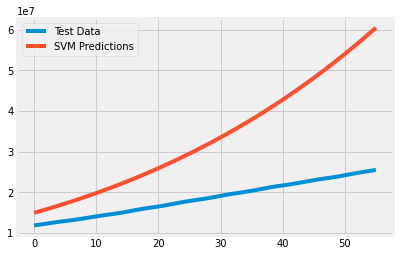

In [20]:
# check against testing data
svm_test_pred = svm_confirmed.predict(X_test_confirmed)
plt.plot(y_test_confirmed)
plt.plot(svm_test_pred)
plt.legend(['Test Data', 'SVM Predictions'])
print('MAE:', mean_absolute_error(svm_test_pred, y_test_confirmed))
print('MSE:',mean_squared_error(svm_test_pred, y_test_confirmed))

In [21]:
# transform our data for polynomial regression
poly = PolynomialFeatures(degree=3)
poly_X_train_confirmed = poly.fit_transform(X_train_confirmed)
poly_X_test_confirmed = poly.fit_transform(X_test_confirmed)
poly_future_forcast = poly.fit_transform(future_forcast)

bayesian_poly = PolynomialFeatures(degree=4)
bayesian_poly_X_train_confirmed = bayesian_poly.fit_transform(X_train_confirmed)
bayesian_poly_X_test_confirmed = bayesian_poly.fit_transform(X_test_confirmed)
bayesian_poly_future_forcast = bayesian_poly.fit_transform(future_forcast)

In [22]:
# polynomial regression
linear_model = LinearRegression(normalize=True, fit_intercept=False)
linear_model.fit(poly_X_train_confirmed, y_train_confirmed)
test_linear_pred = linear_model.predict(poly_X_test_confirmed)
linear_pred = linear_model.predict(poly_future_forcast)
print('MAE:', mean_absolute_error(test_linear_pred, y_test_confirmed))
print('MSE:',mean_squared_error(test_linear_pred, y_test_confirmed))

MAE: 1886265.94797985
MSE: 4381792019029.0166


In [23]:
print(linear_model.coef_)

[[ 2.11595538e+05 -2.61923693e+04  5.50775050e+02  6.78790792e-02]]


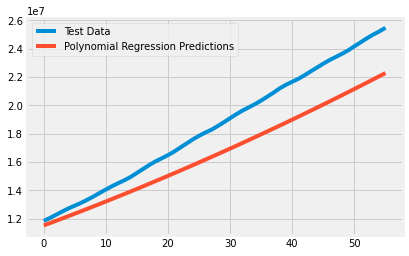

In [24]:
plt.plot(y_test_confirmed)
plt.plot(test_linear_pred)
plt.legend(['Test Data', 'Polynomial Regression Predictions'])

In [25]:
# bayesian ridge polynomial regression
tol = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
alpha_1 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
alpha_2 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
lambda_1 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
lambda_2 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
normalize = [True, False]

bayesian_grid = {'tol': tol, 'alpha_1': alpha_1, 'alpha_2' : alpha_2, 'lambda_1': lambda_1, 'lambda_2' : lambda_2, 
                 'normalize' : normalize}

bayesian = BayesianRidge(fit_intercept=False)
bayesian_search = RandomizedSearchCV(bayesian, bayesian_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=40, verbose=1)
bayesian_search.fit(bayesian_poly_X_train_confirmed, y_train_confirmed)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.7s finished
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=BayesianRidge(alpha_1=1e-06, alpha_2=1e-06,
                                           alpha_init=None, compute_score=False,
                                           copy_X=True, fit_intercept=False,
                                           lambda_1=1e-06, lambda_2=1e-06,
                                           lambda_init=None, n_iter=300,
                                           normalize=False, tol=0.001,
                                           verbose=False),
                   iid='deprecated', n_iter=40, n_jobs=-1,
                   param_distributions={'alpha_1': [1e-07, 1e-06, 1e-05, 0.0001,
                                                    0.001],
                                        'alpha_2': [1e-07, 1e-06, 1e-05, 0.0001,
                                                    0.001],
                                        'lambda_1': [1e-07, 1e-06, 1e-05,
                                  

In [26]:
bayesian_search.best_params_

{'tol': 1e-05,
 'normalize': True,
 'lambda_2': 0.001,
 'lambda_1': 1e-06,
 'alpha_2': 0.001,
 'alpha_1': 1e-07}

In [27]:
bayesian_confirmed = bayesian_search.best_estimator_
test_bayesian_pred = bayesian_confirmed.predict(bayesian_poly_X_test_confirmed)
bayesian_pred = bayesian_confirmed.predict(bayesian_poly_future_forcast)
print('MAE:', mean_absolute_error(test_bayesian_pred, y_test_confirmed))
print('MSE:',mean_squared_error(test_bayesian_pred, y_test_confirmed))

MAE: 2201155.7401767415
MSE: 6304920369816.842


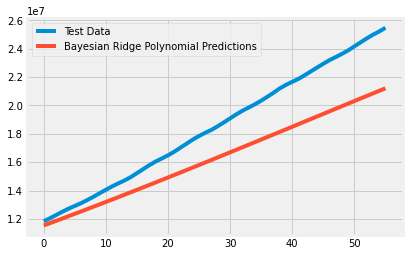

In [28]:
plt.plot(y_test_confirmed)
plt.plot(test_bayesian_pred)
plt.legend(['Test Data', 'Bayesian Ridge Polynomial Predictions'])

 Graphing the number of confirmed cases, active cases, deaths, recoveries, mortality rate, and recovery rate

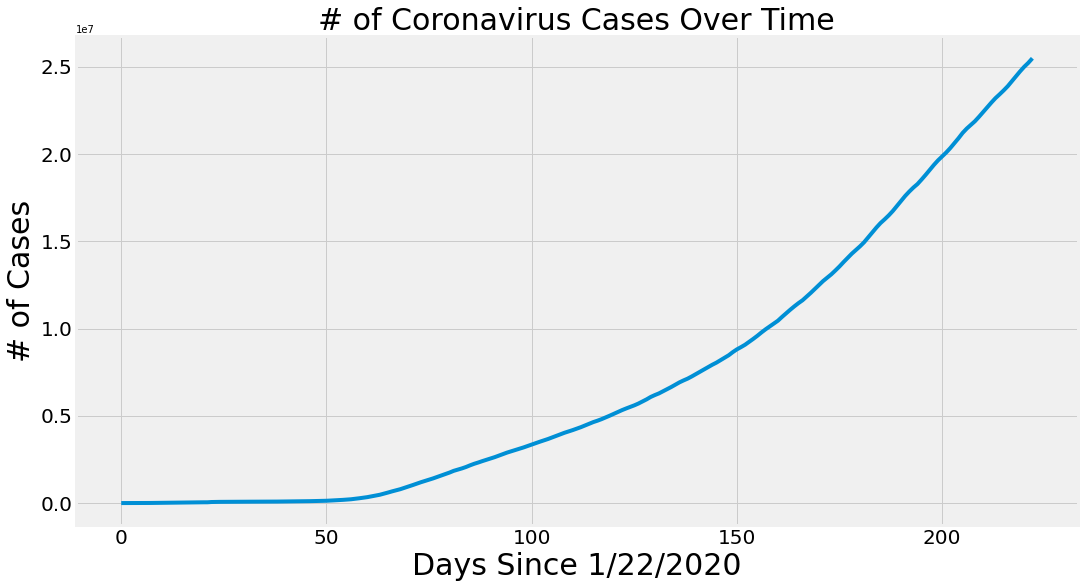

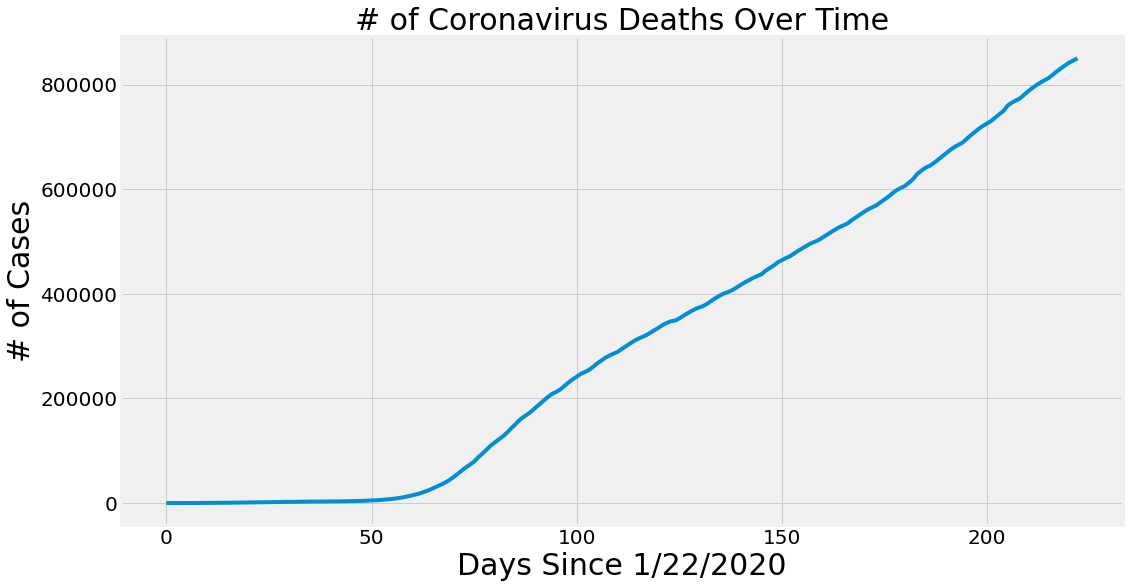

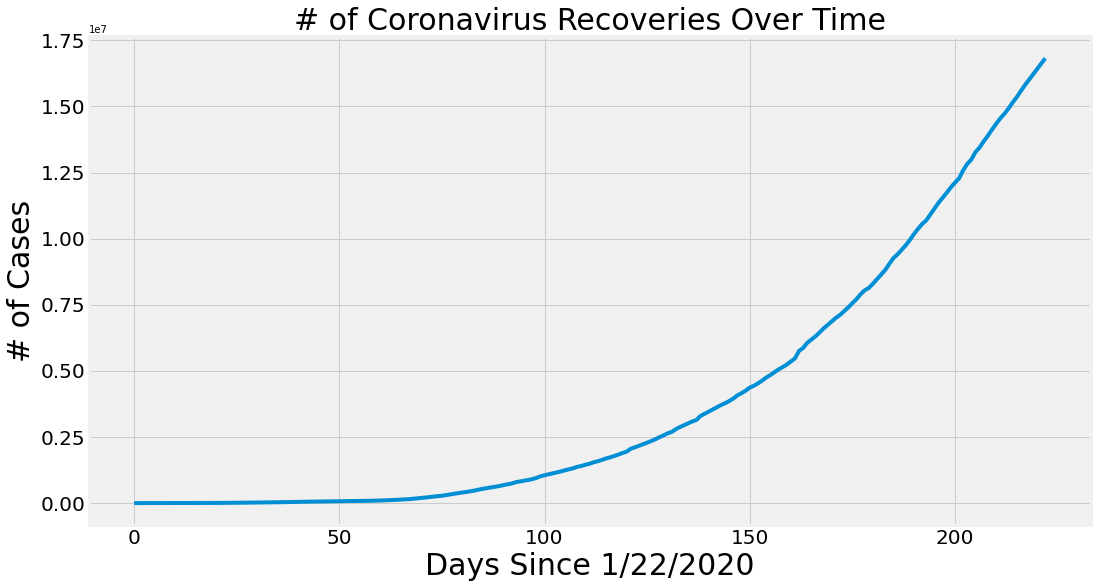

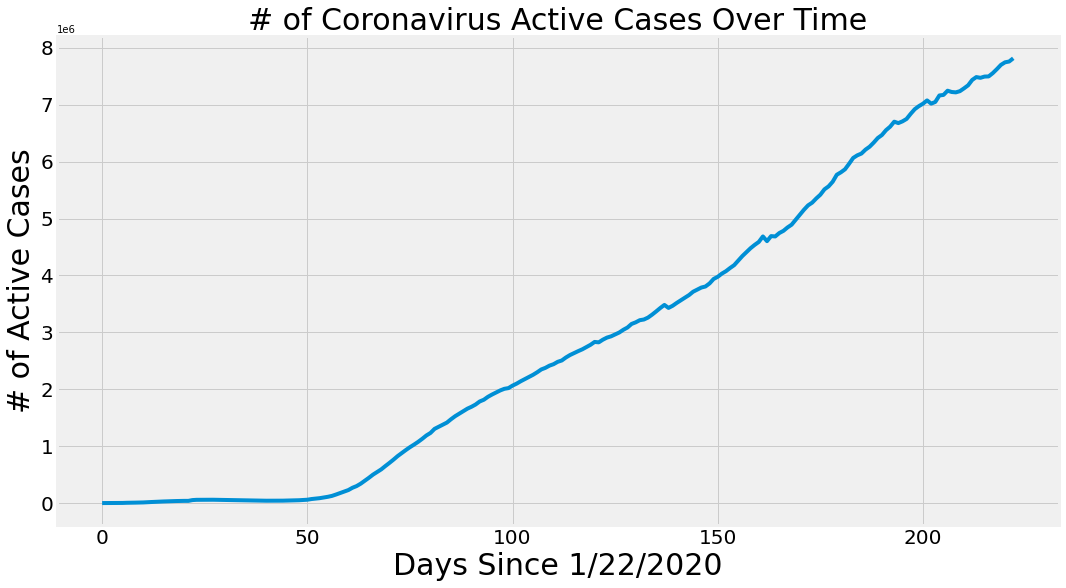

In [29]:
adjusted_dates = adjusted_dates.reshape(1, -1)[0]
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, world_cases)
plt.title('# of Coronavirus Cases Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, total_deaths)
plt.title('# of Coronavirus Deaths Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, total_recovered)
plt.title('# of Coronavirus Recoveries Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, total_active)
plt.title('# of Coronavirus Active Cases Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Active Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

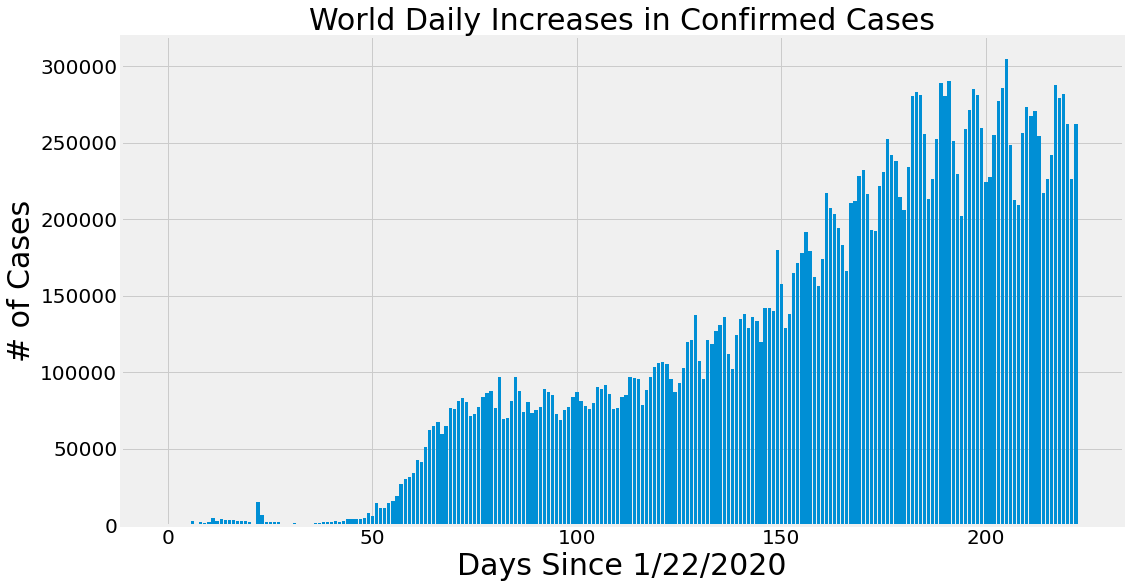

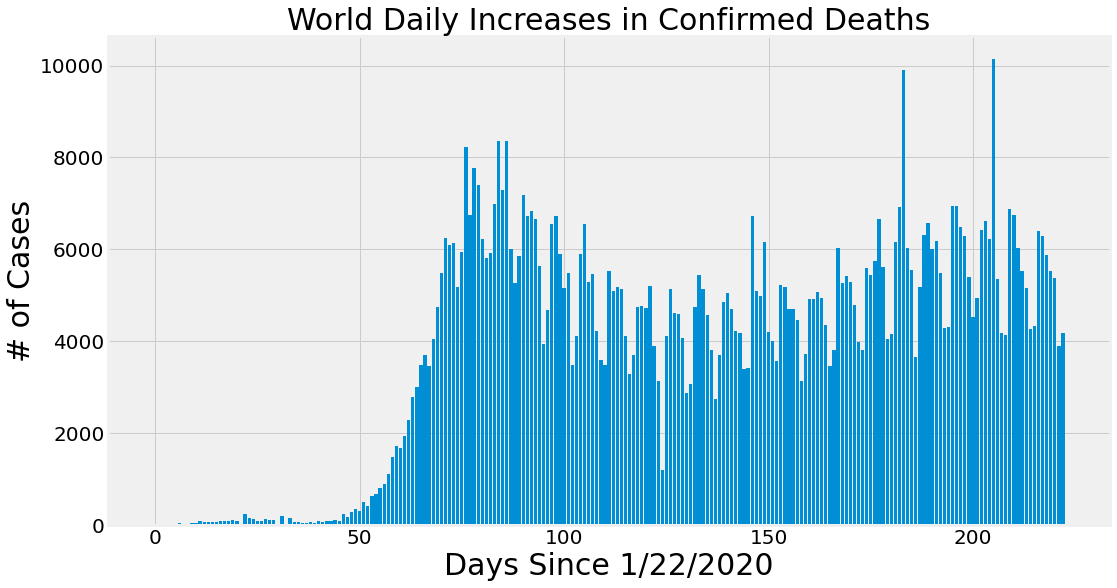

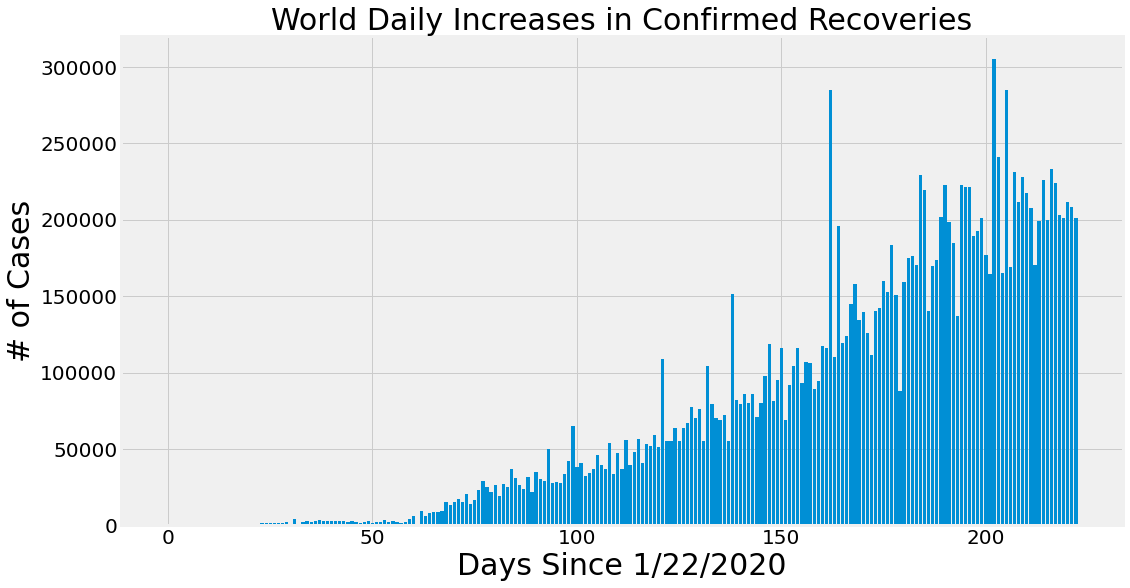

In [30]:
plt.figure(figsize=(16, 9))
plt.bar(adjusted_dates, world_daily_increase)
plt.title('World Daily Increases in Confirmed Cases', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 9))
plt.bar(adjusted_dates, world_daily_death)
plt.title('World Daily Increases in Confirmed Deaths', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 9))
plt.bar(adjusted_dates, world_daily_recovery)
plt.title('World Daily Increases in Confirmed Recoveries', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

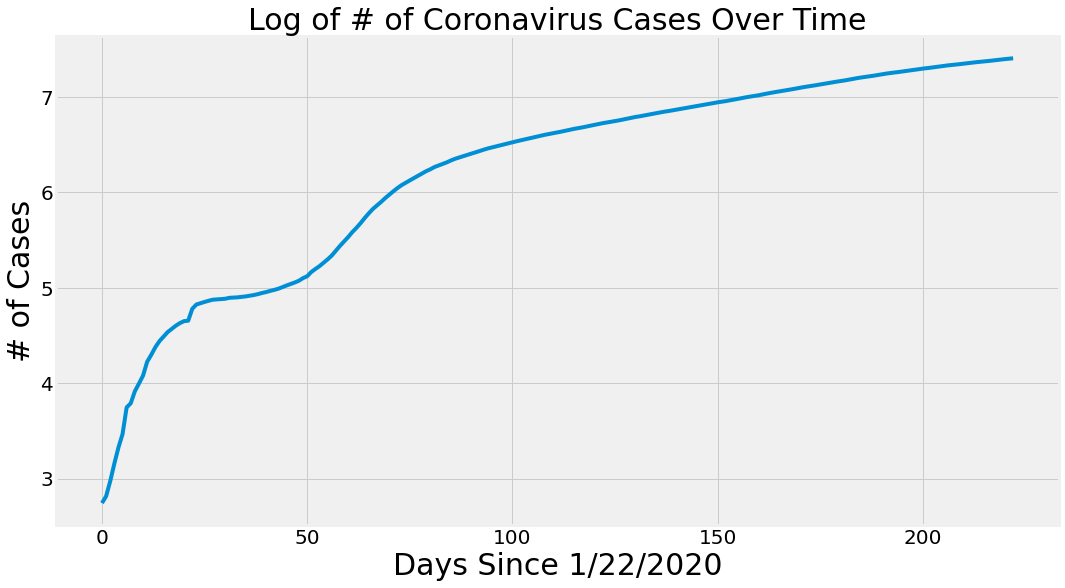

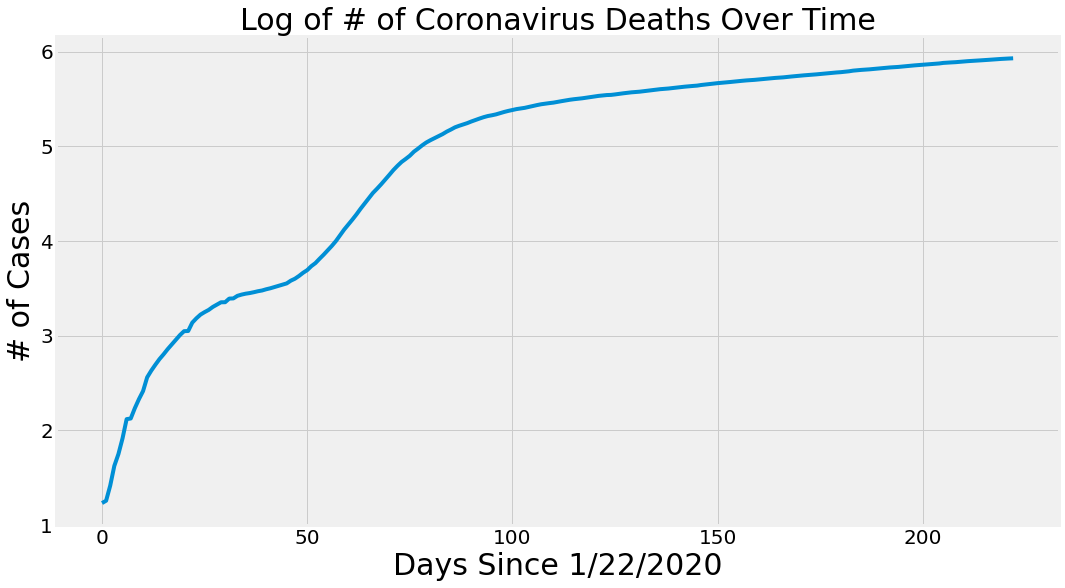

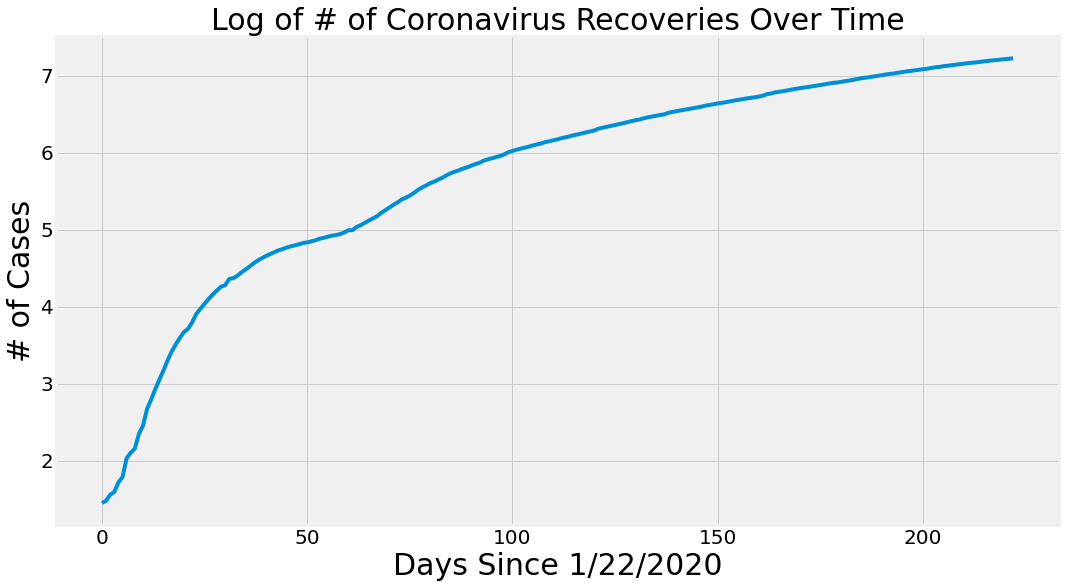

In [31]:
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, np.log10(world_cases))
plt.title('Log of # of Coronavirus Cases Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, np.log10(total_deaths))
plt.title('Log of # of Coronavirus Deaths Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, np.log10(total_recovered))
plt.title('Log of # of Coronavirus Recoveries Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [32]:
def country_plot(x, y1, y2, y3, y4, country):
    plt.figure(figsize=(16, 9))
    plt.plot(x, y1)
    plt.title('{} Confirmed Cases'.format(country), size=30)
    plt.xlabel('Days Since 1/22/2020', size=30)
    plt.ylabel('# of Cases', size=30)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()

    plt.figure(figsize=(16, 9))
    plt.bar(x, y2)
    plt.title('{} Daily Increases in Confirmed Cases'.format(country), size=30)
    plt.xlabel('Days Since 1/22/2020', size=30)
    plt.ylabel('# of Cases', size=30)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()

    plt.figure(figsize=(16, 9))
    plt.bar(x, y3)
    plt.title('{} Daily Increases in Deaths'.format(country), size=30)
    plt.xlabel('Days Since 1/22/2020', size=30)
    plt.ylabel('# of Cases', size=30)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()

    plt.figure(figsize=(16, 9))
    plt.bar(x, y4)
    plt.title('{} Daily Increases in Recoveries'.format(country), size=30)
    plt.xlabel('Days Since 1/22/2020', size=30)
    plt.ylabel('# of Cases', size=30)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()

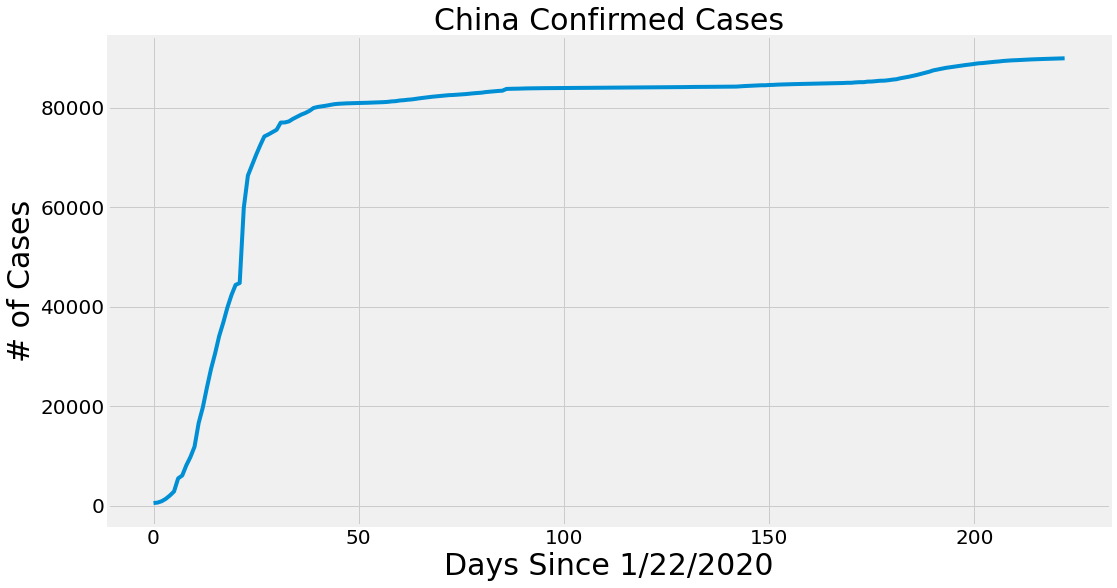

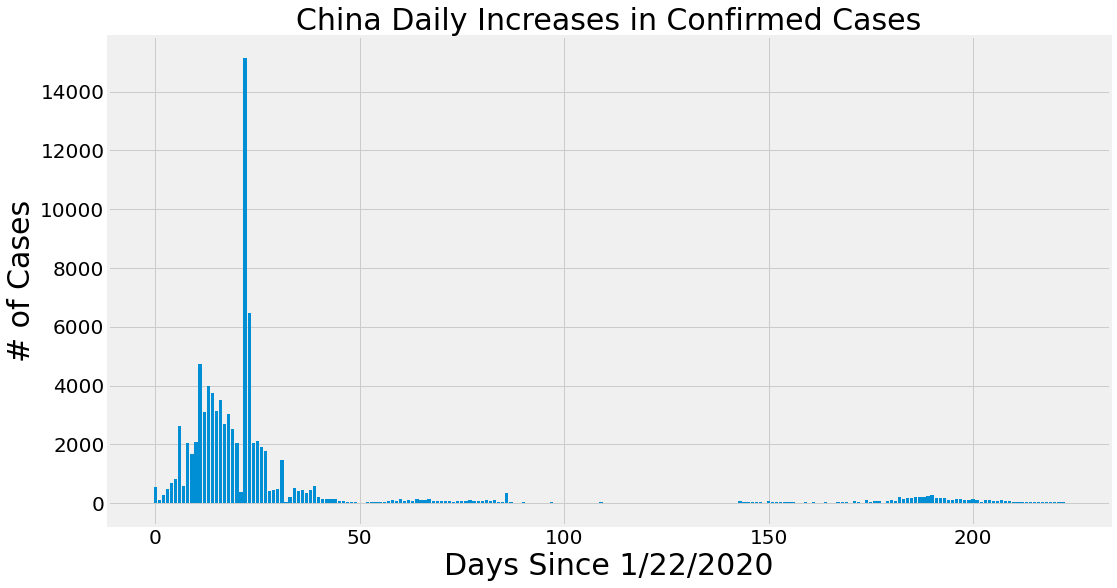

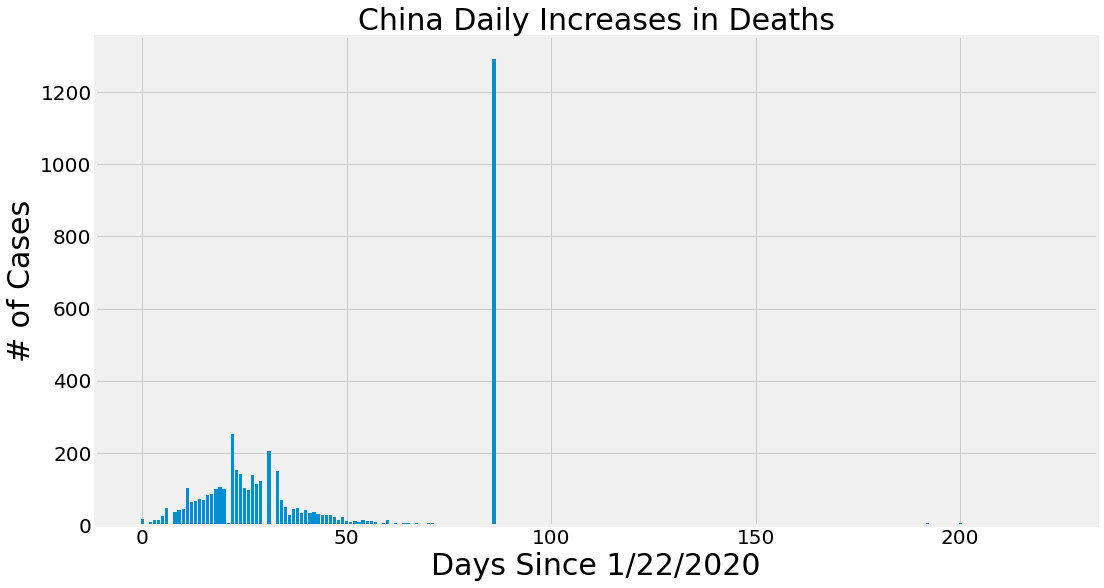

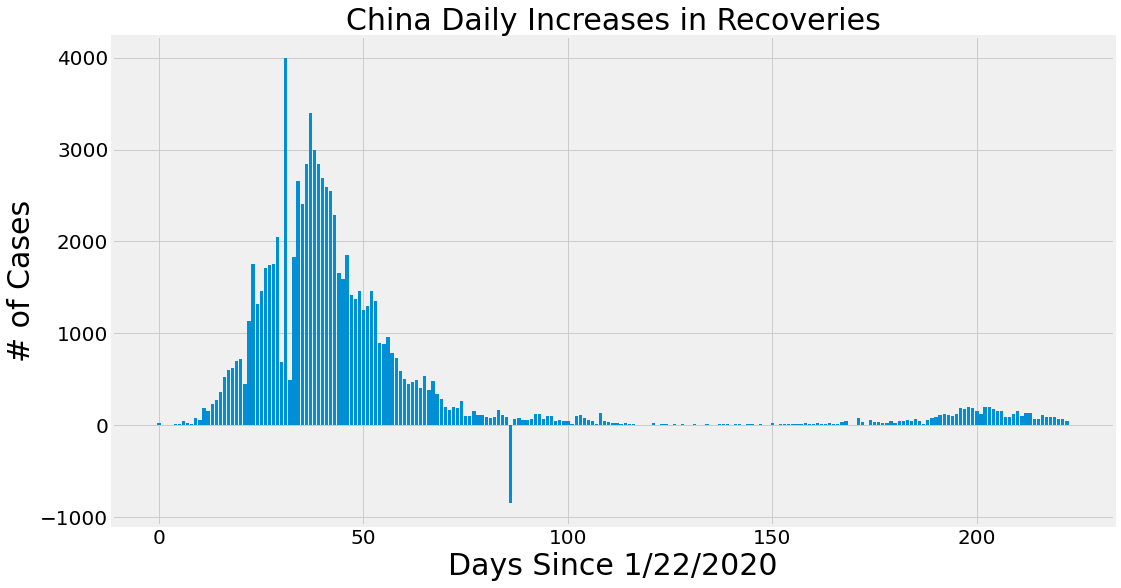

In [33]:
country_plot(adjusted_dates, china_cases, china_daily_increase, china_daily_death, china_daily_recovery, 'China')

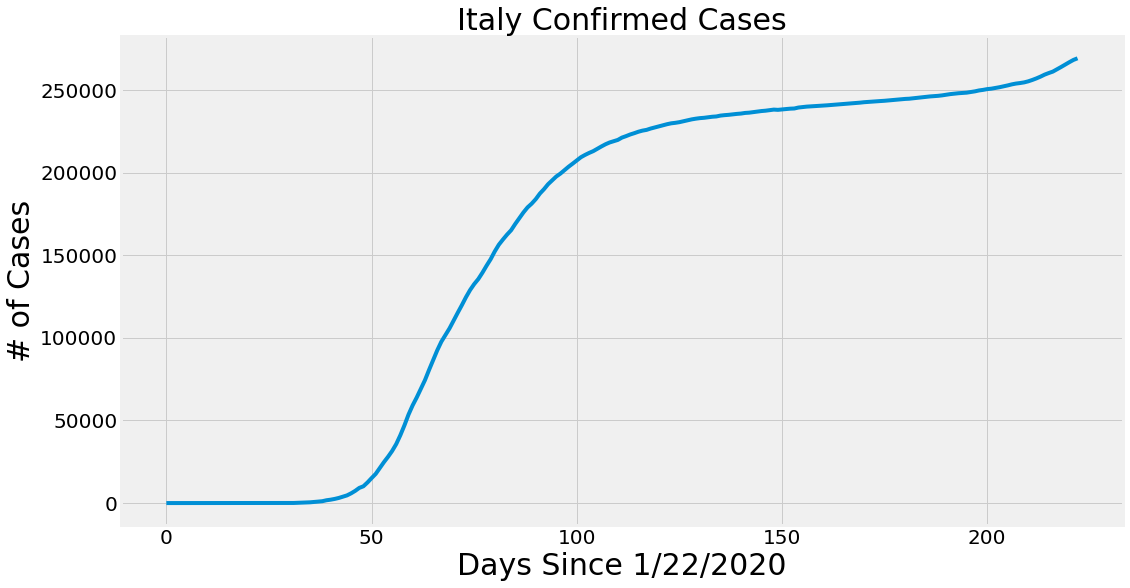

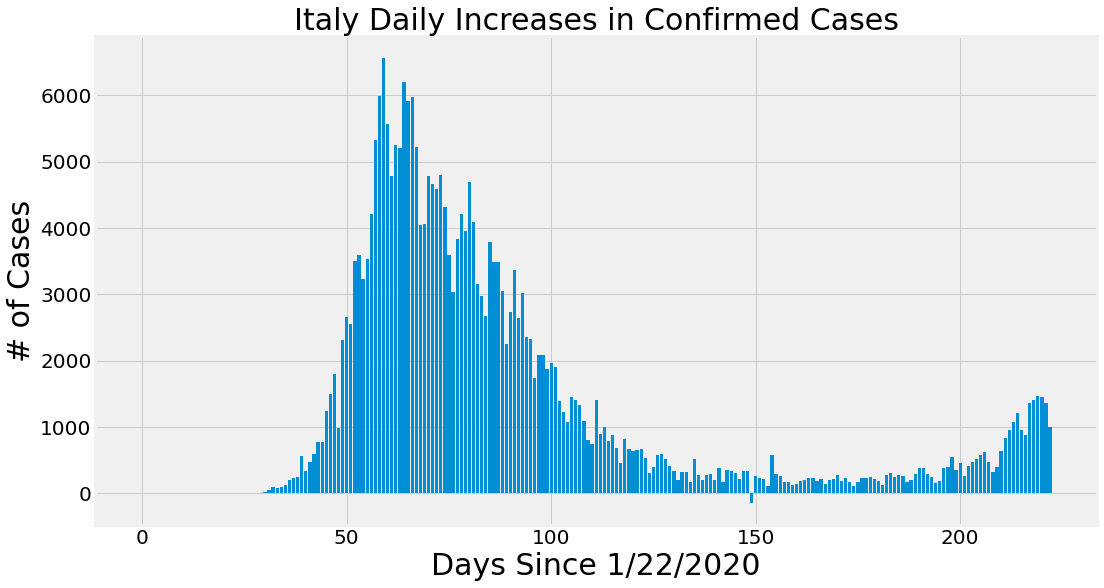

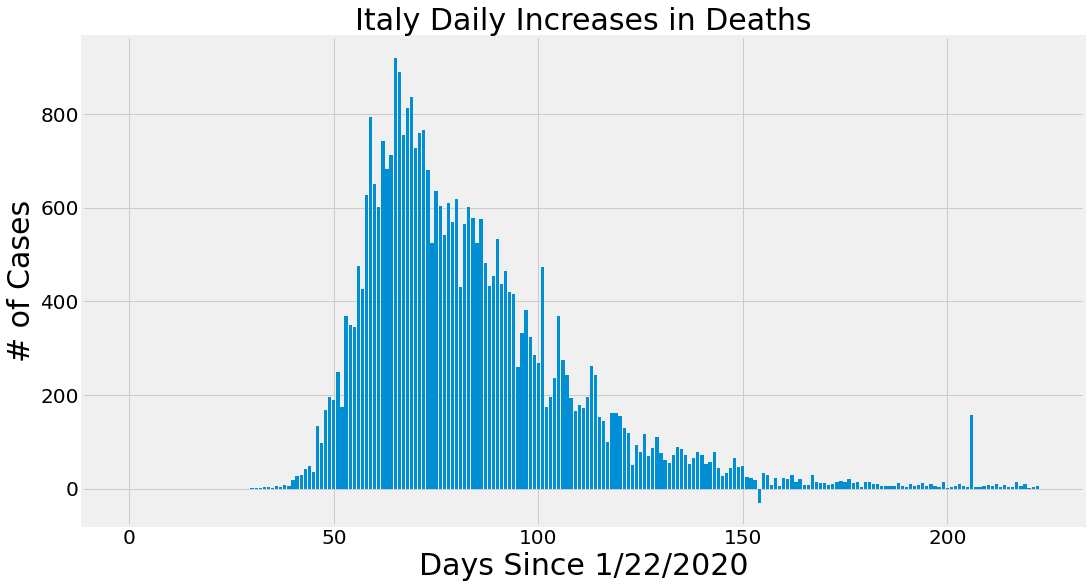

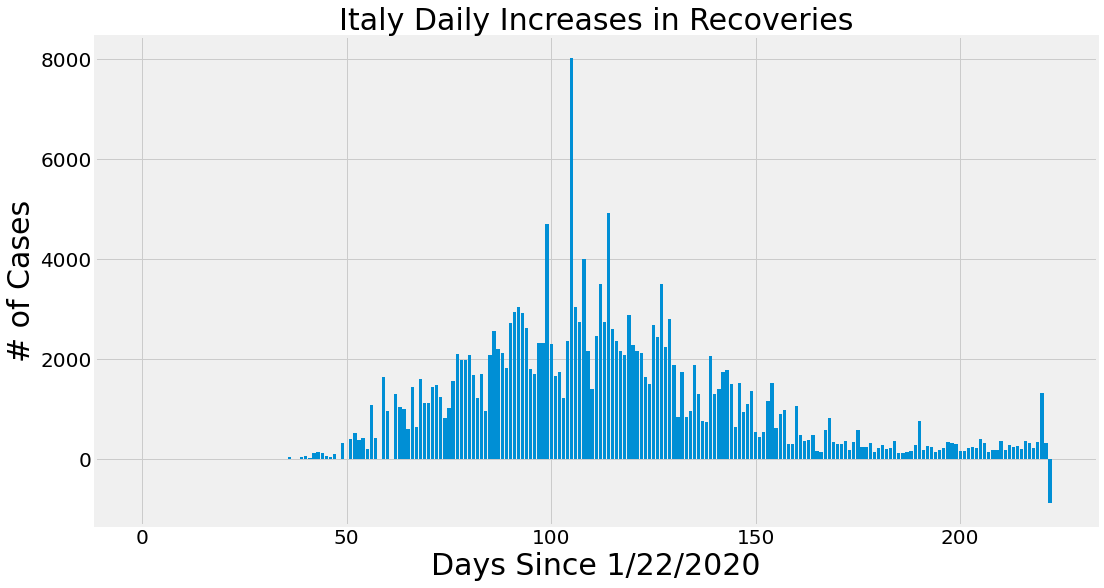

In [34]:
country_plot(adjusted_dates, italy_cases, italy_daily_increase, italy_daily_death, italy_daily_recovery, 'Italy')

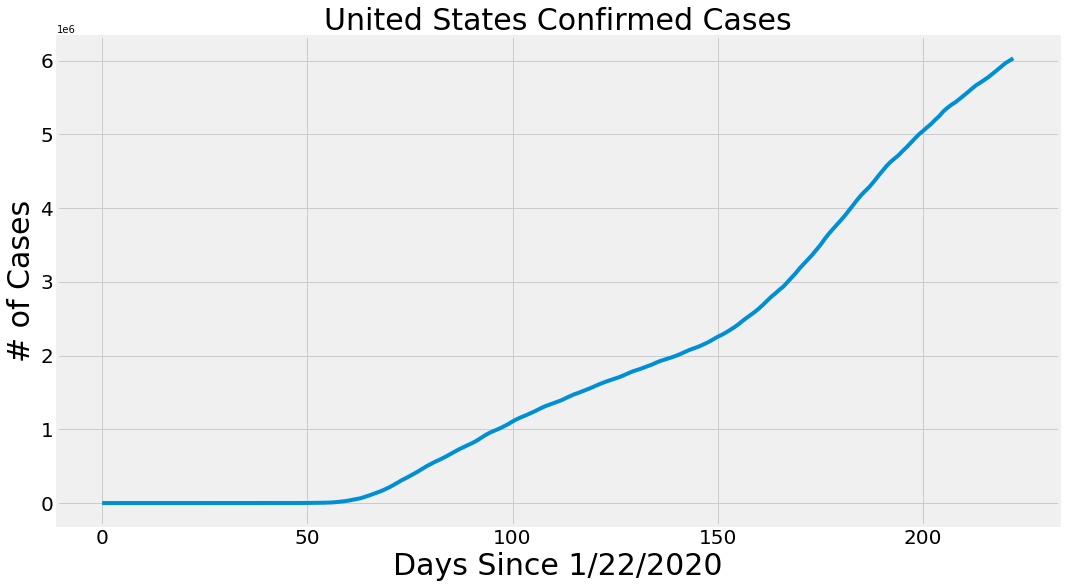

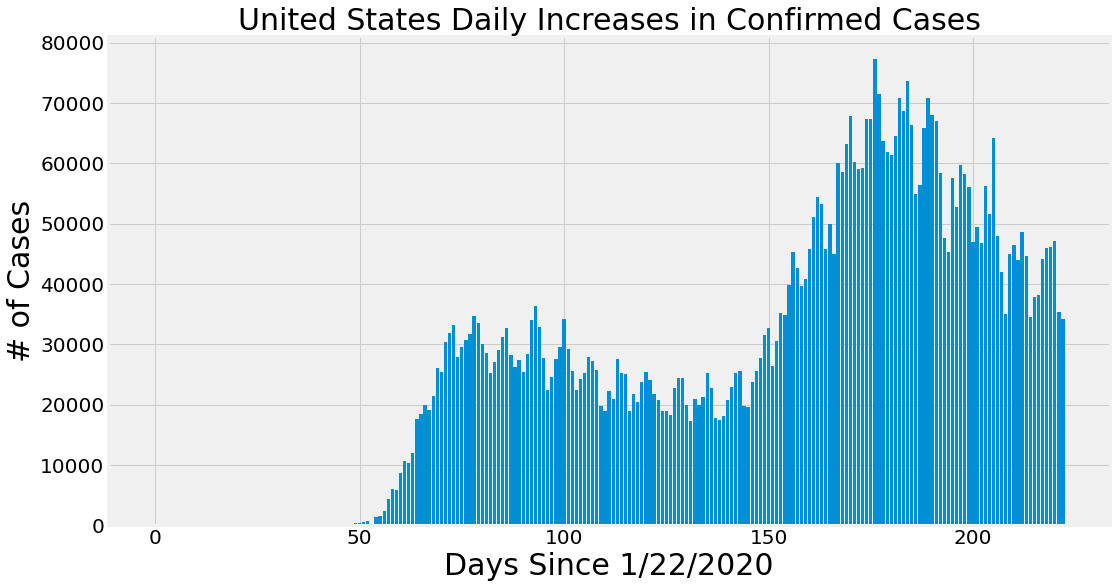

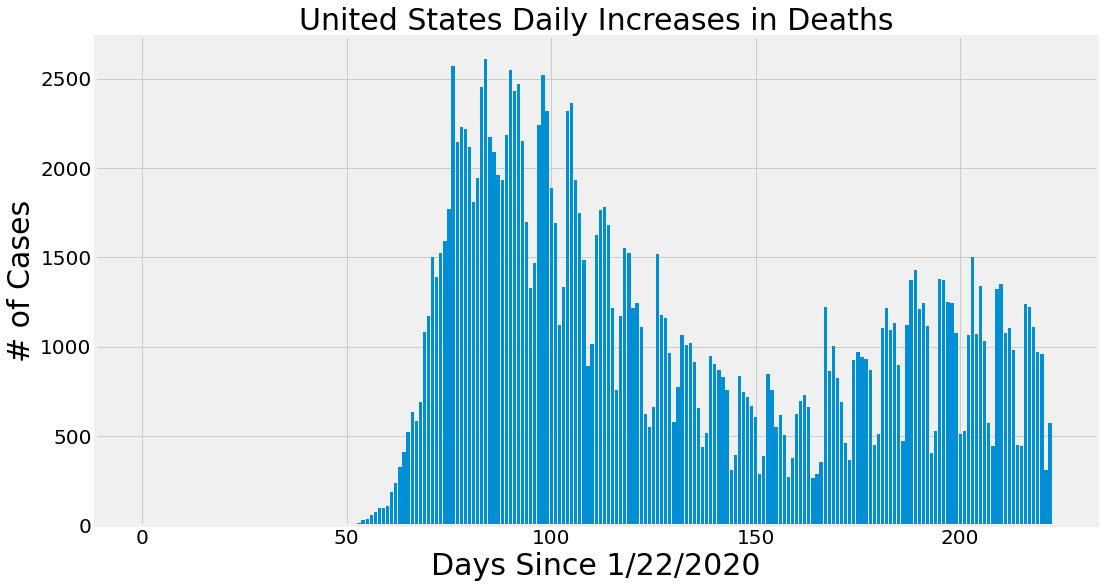

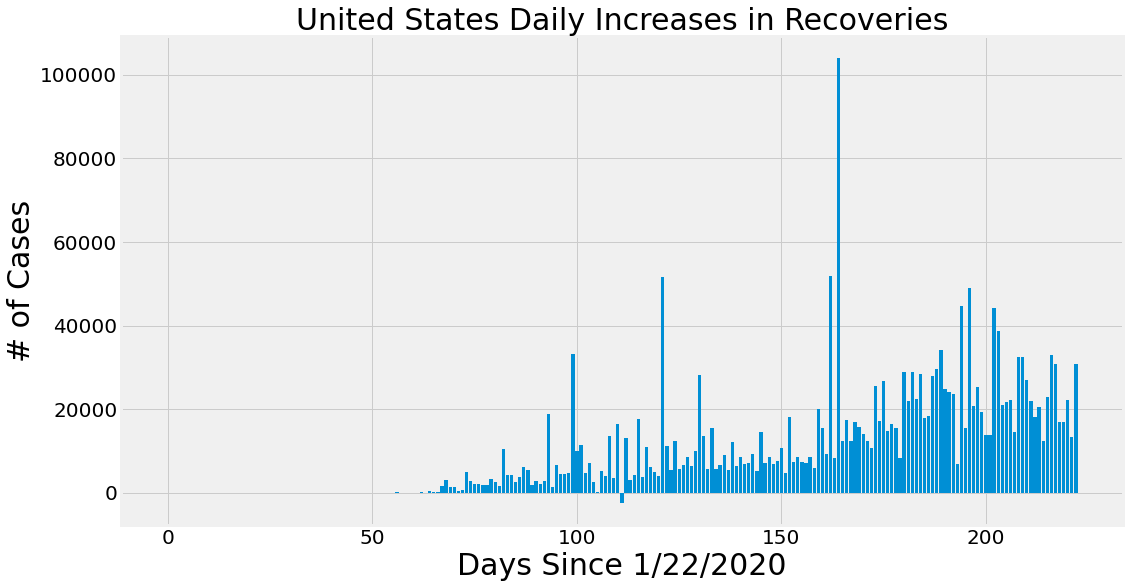

In [35]:
country_plot(adjusted_dates, us_cases, us_daily_increase, us_daily_death, us_daily_recovery, 'United States')

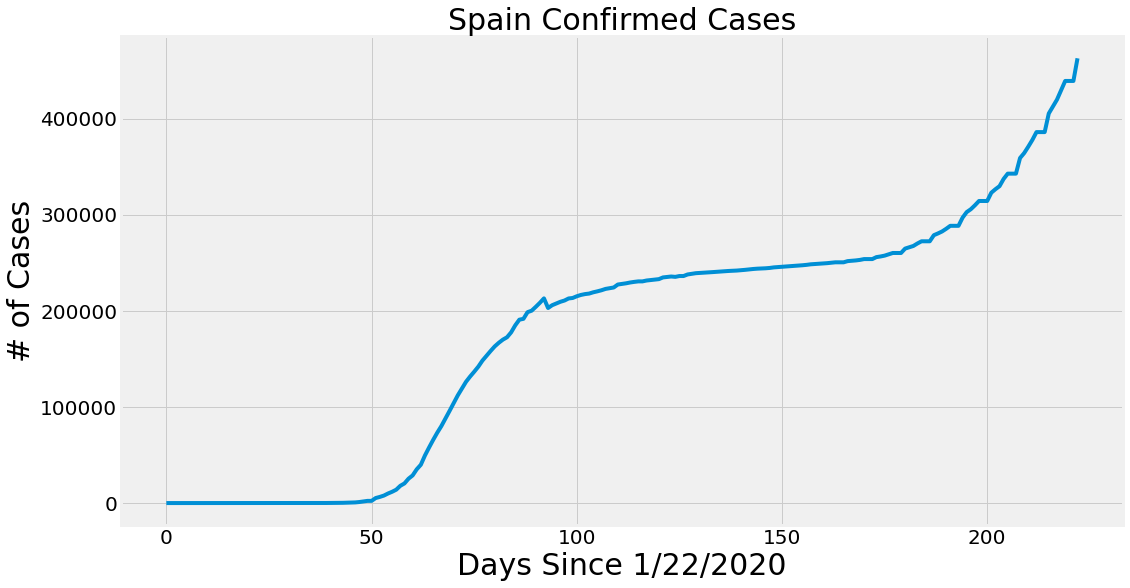

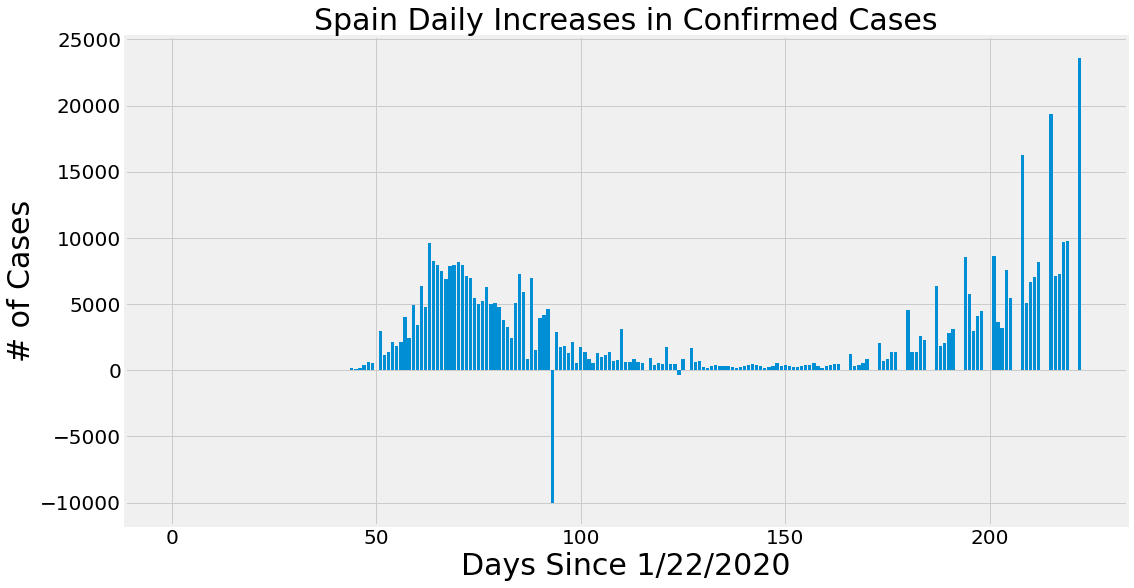

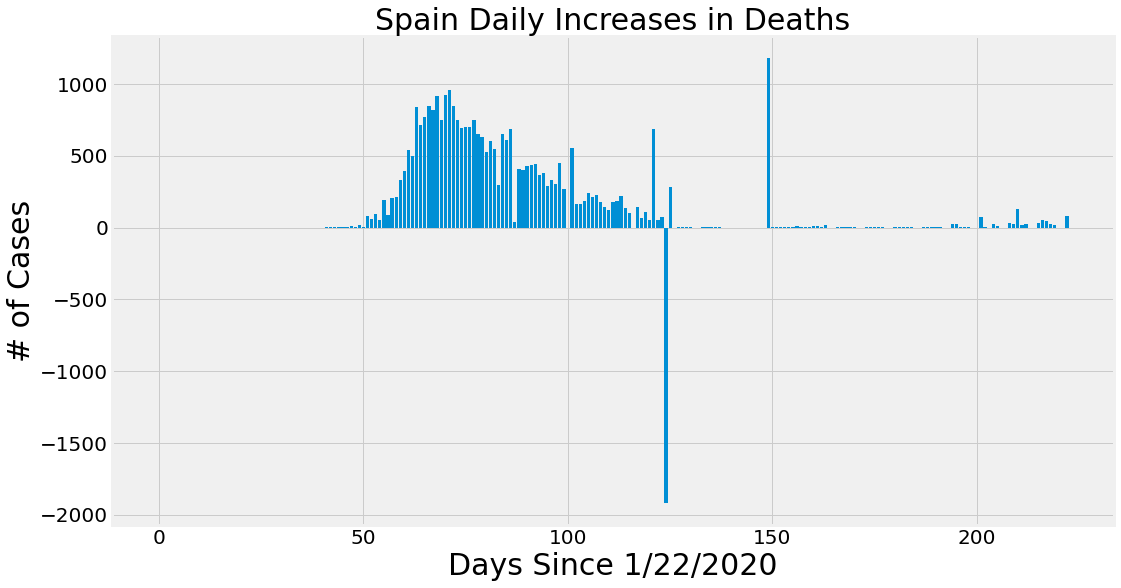

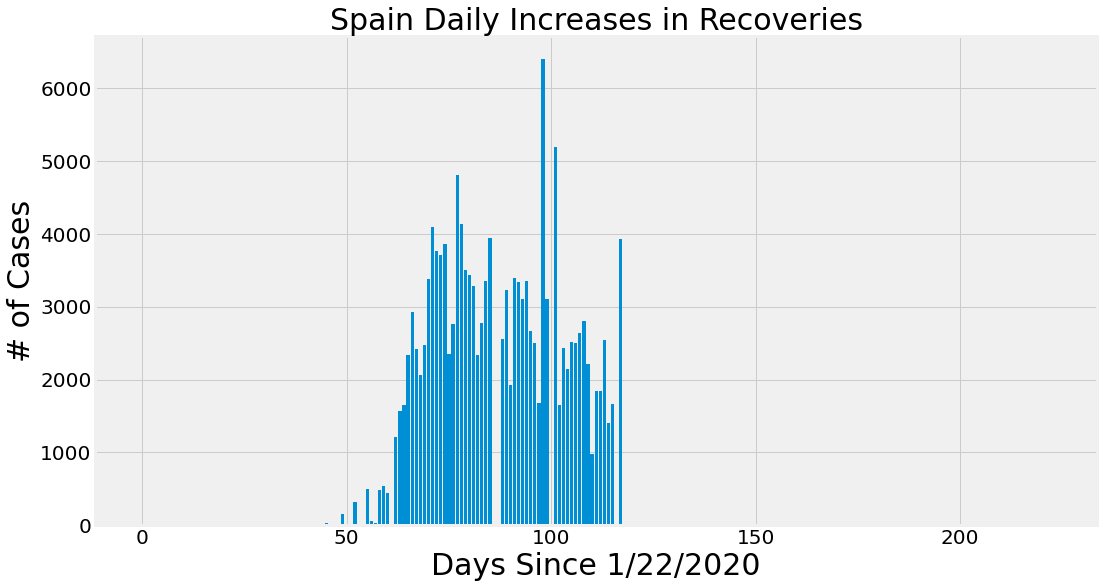

In [36]:
country_plot(adjusted_dates, spain_cases, spain_daily_increase, spain_daily_death, spain_daily_recovery, 'Spain')

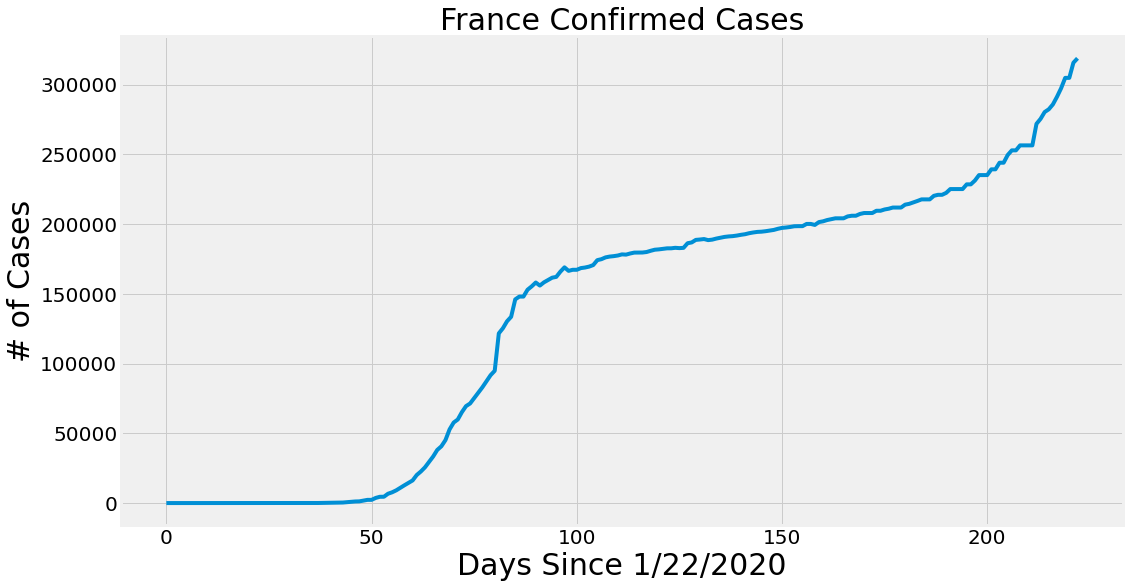

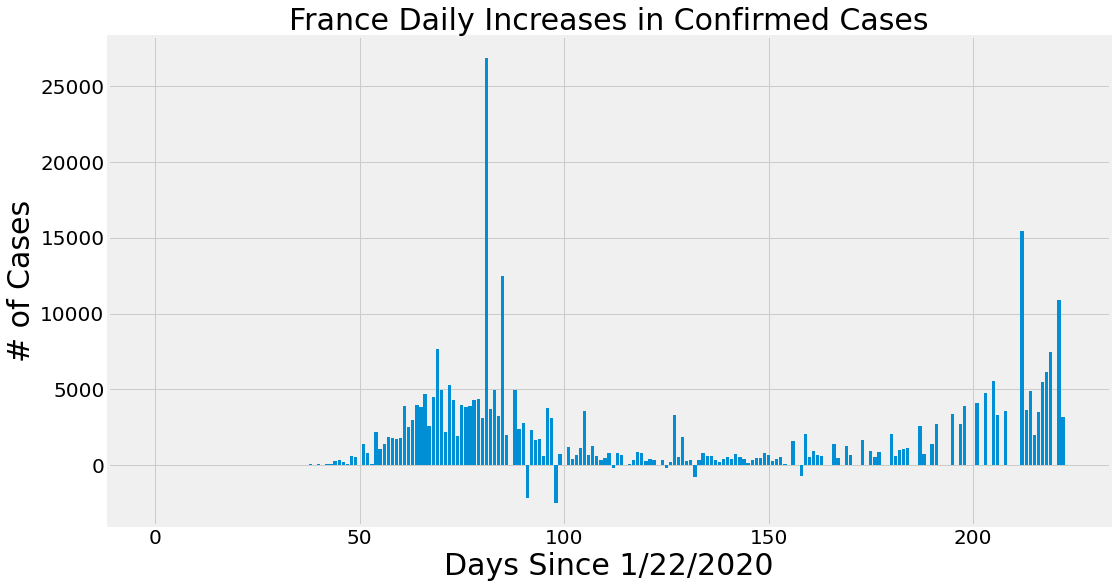

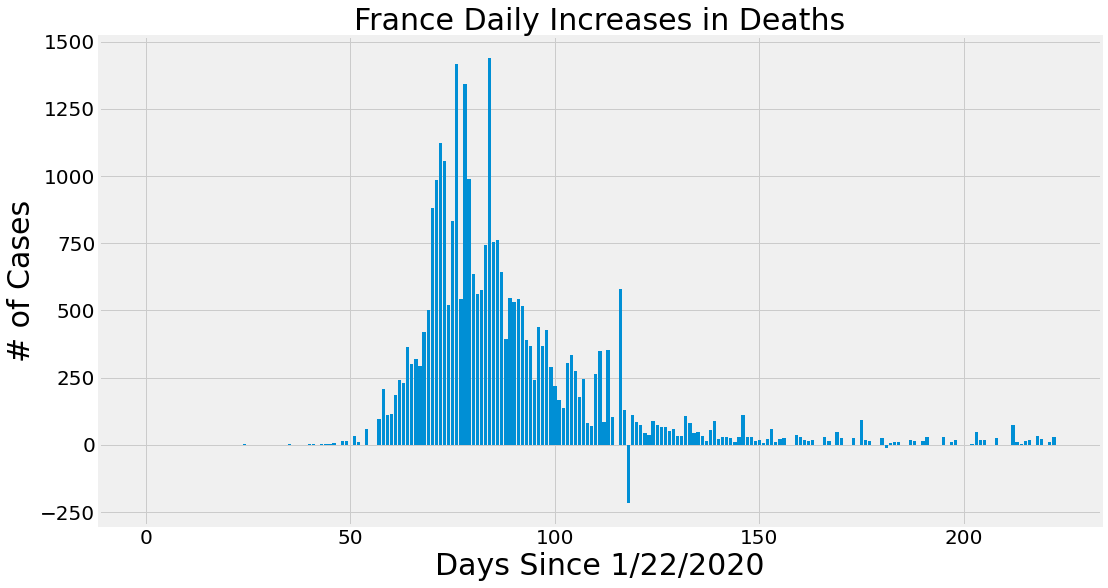

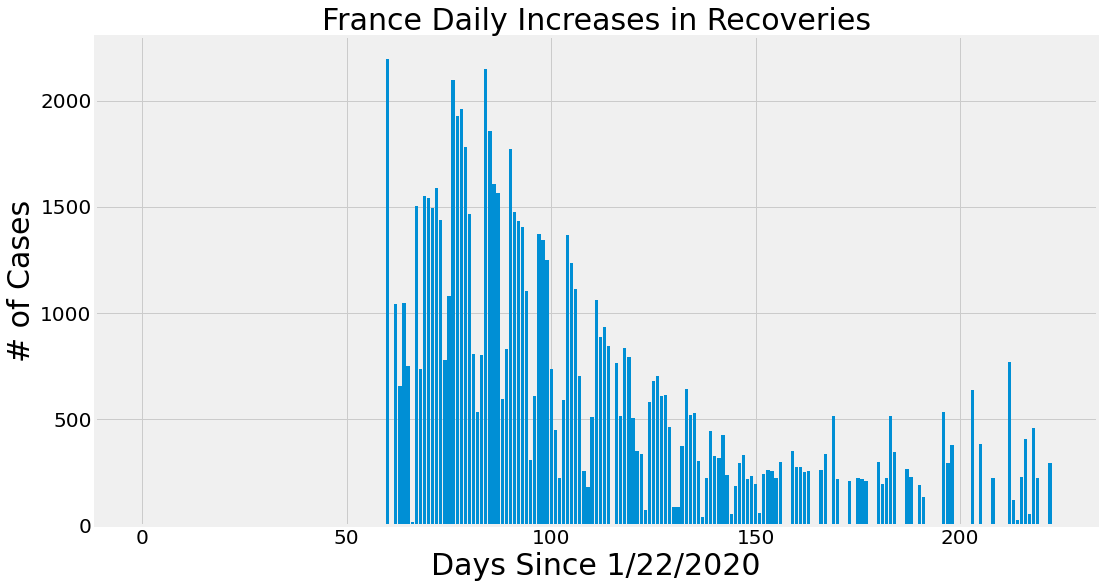

In [37]:
country_plot(adjusted_dates, france_cases, france_daily_increase, france_daily_death, france_daily_recovery, 'France')

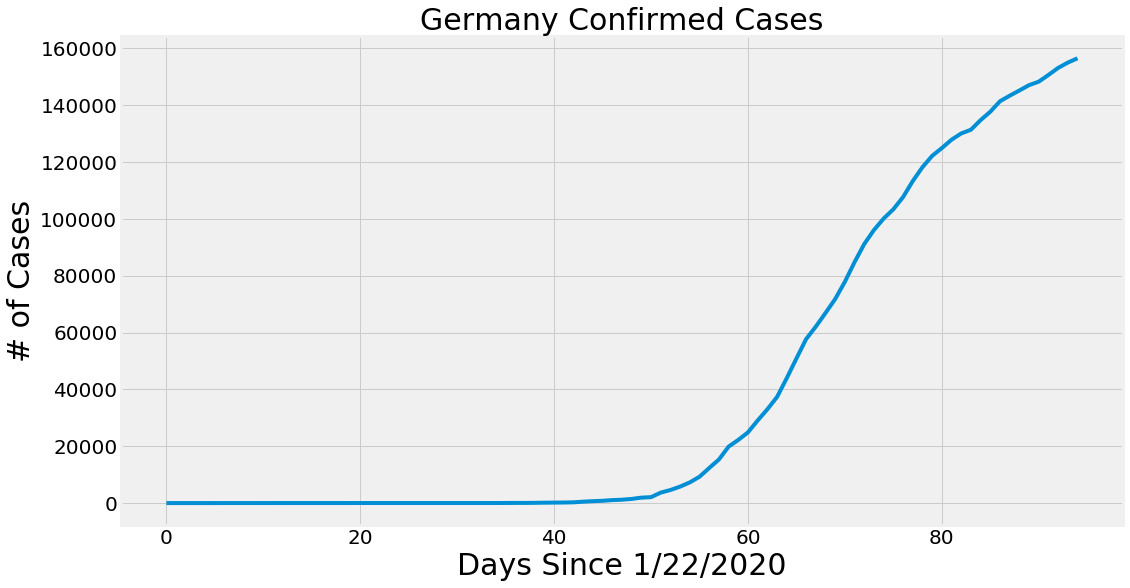

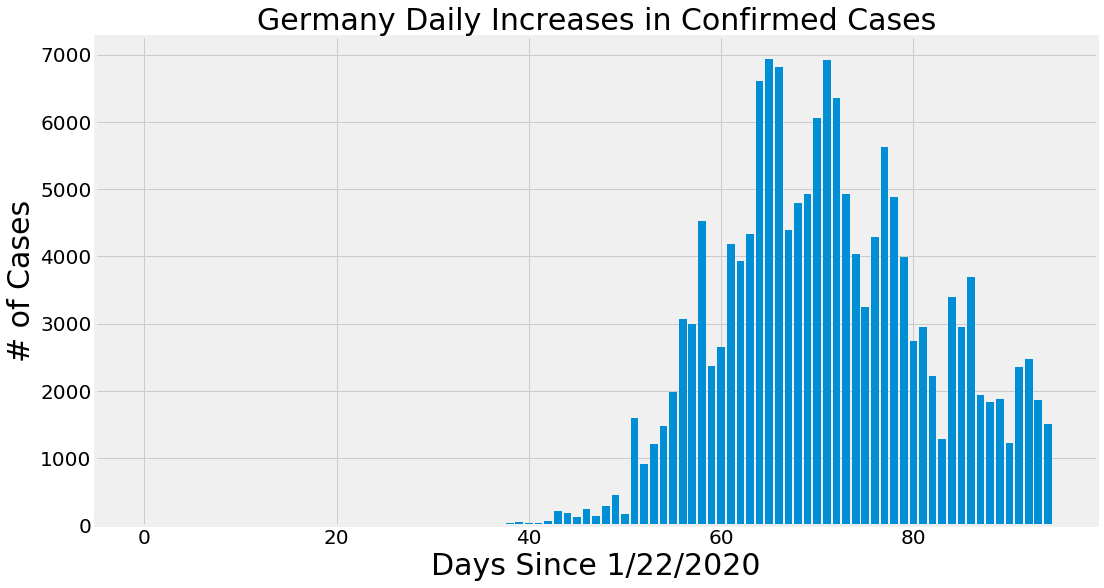

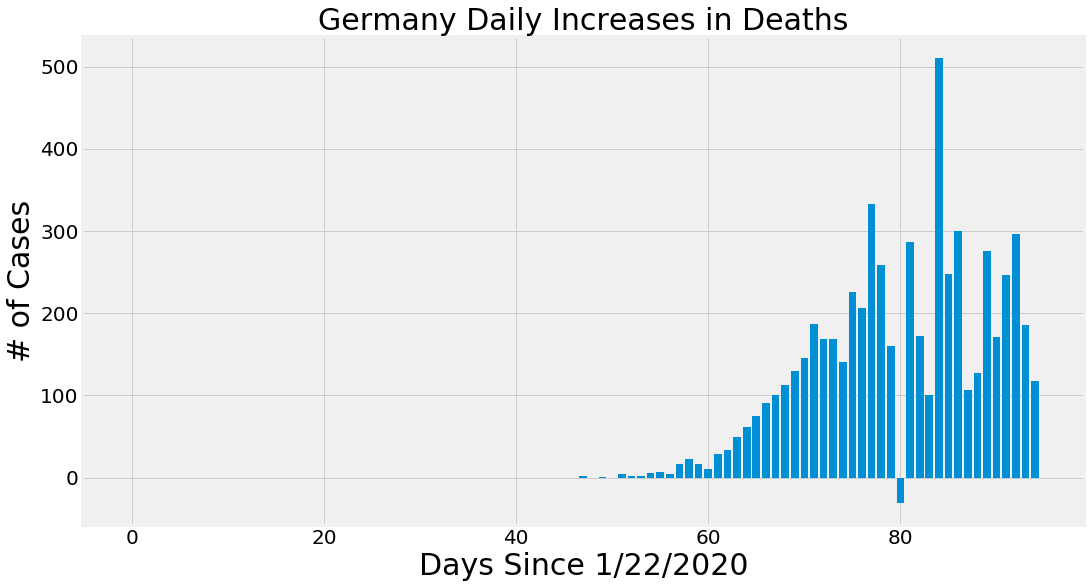

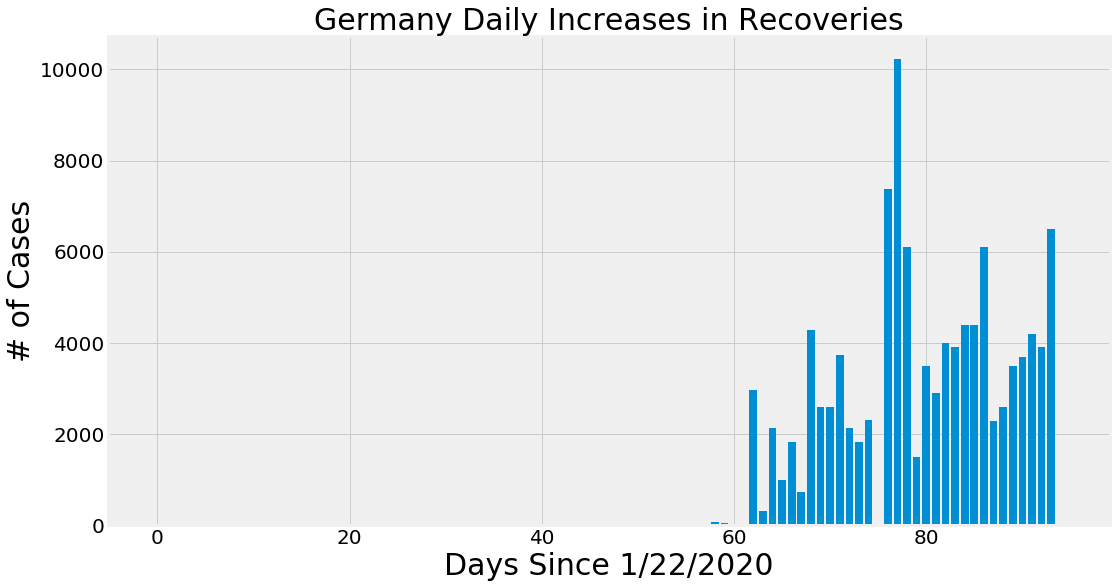

In [35]:
country_plot(adjusted_dates, germany_cases, germany_daily_increase, germany_daily_death, germany_daily_recovery, 'Germany')

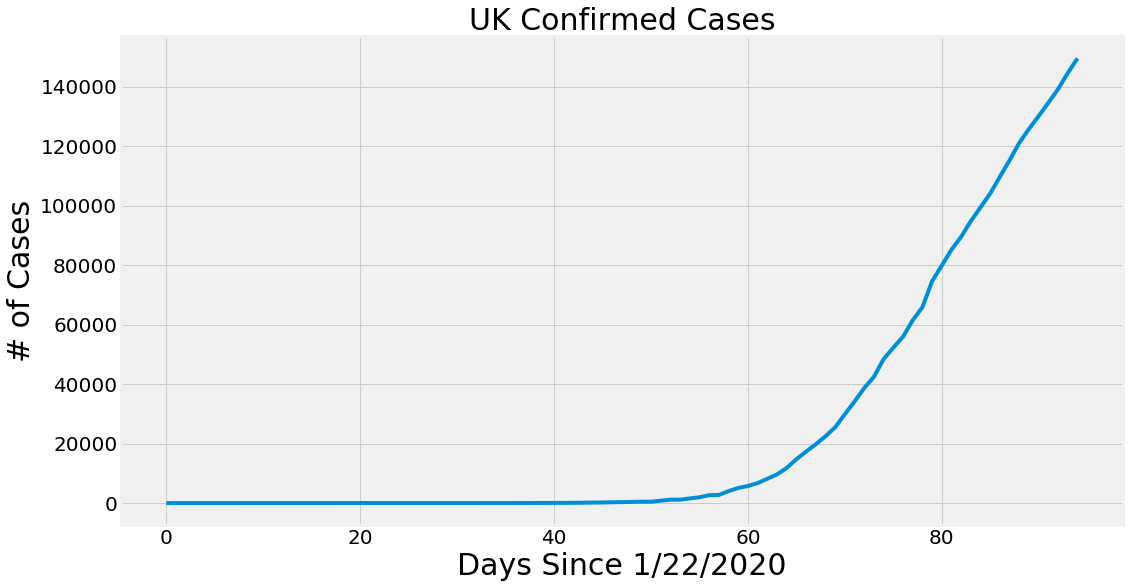

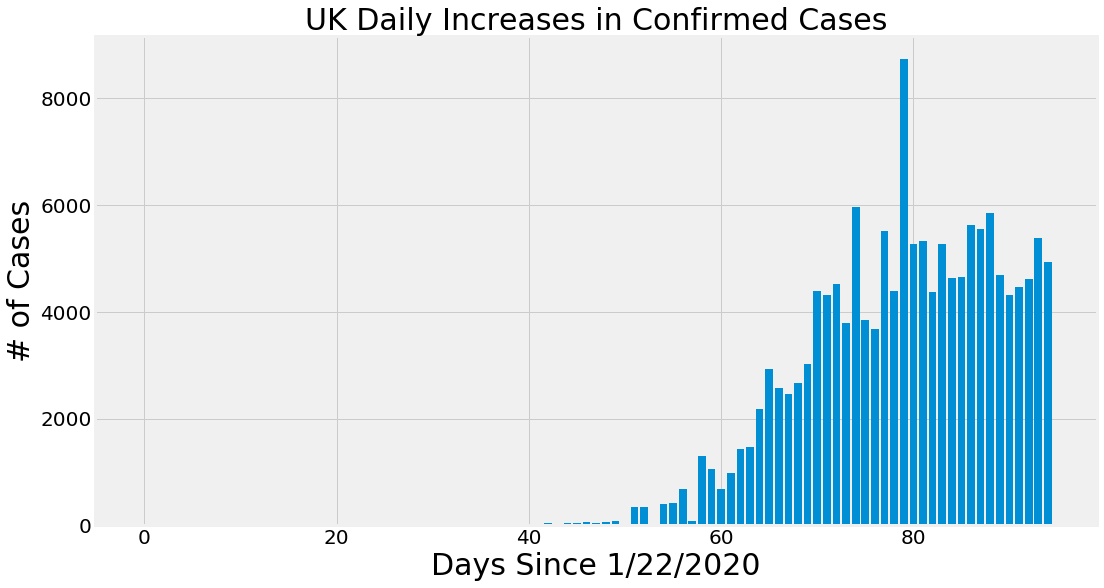

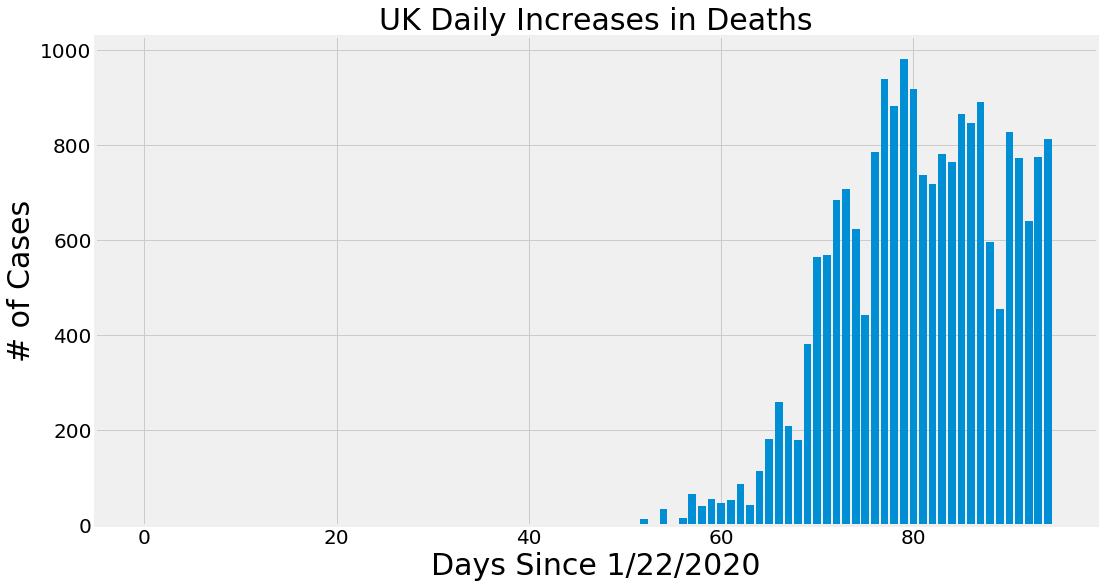

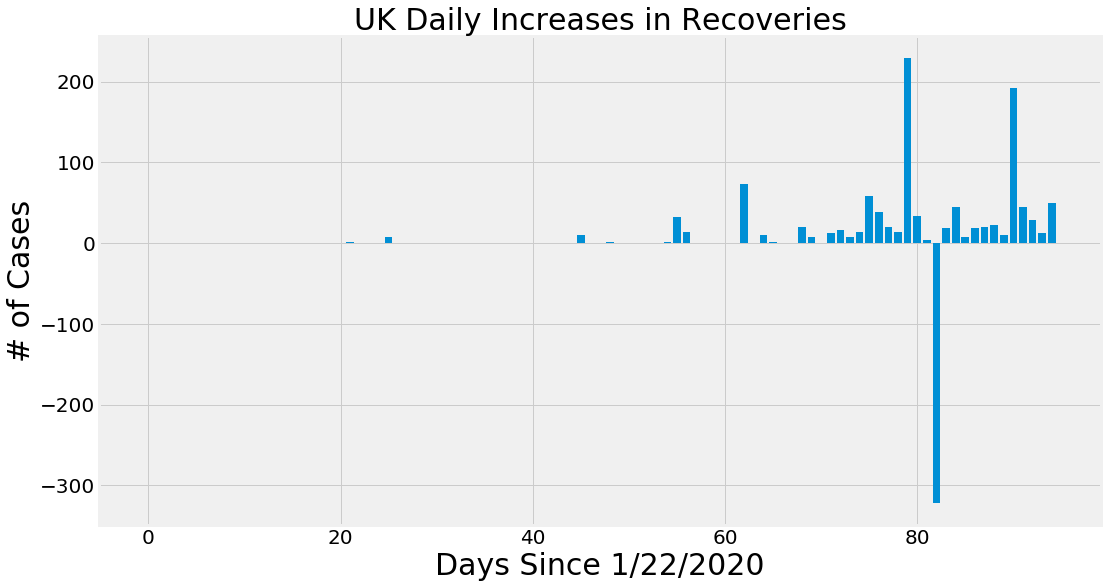

In [36]:
country_plot(adjusted_dates, uk_cases, uk_daily_increase, uk_daily_death, uk_daily_recovery, 'UK')

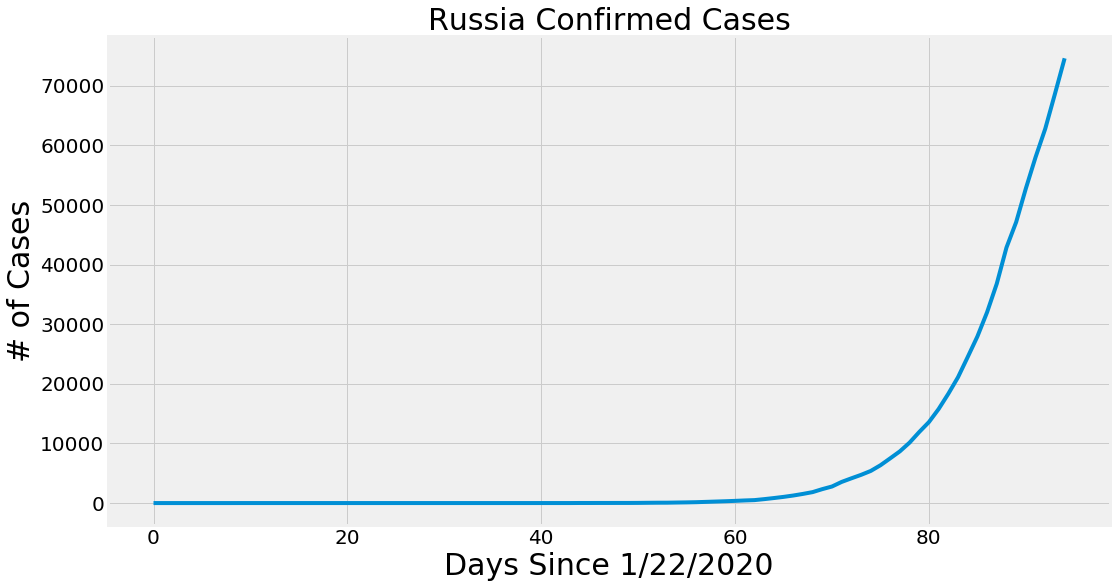

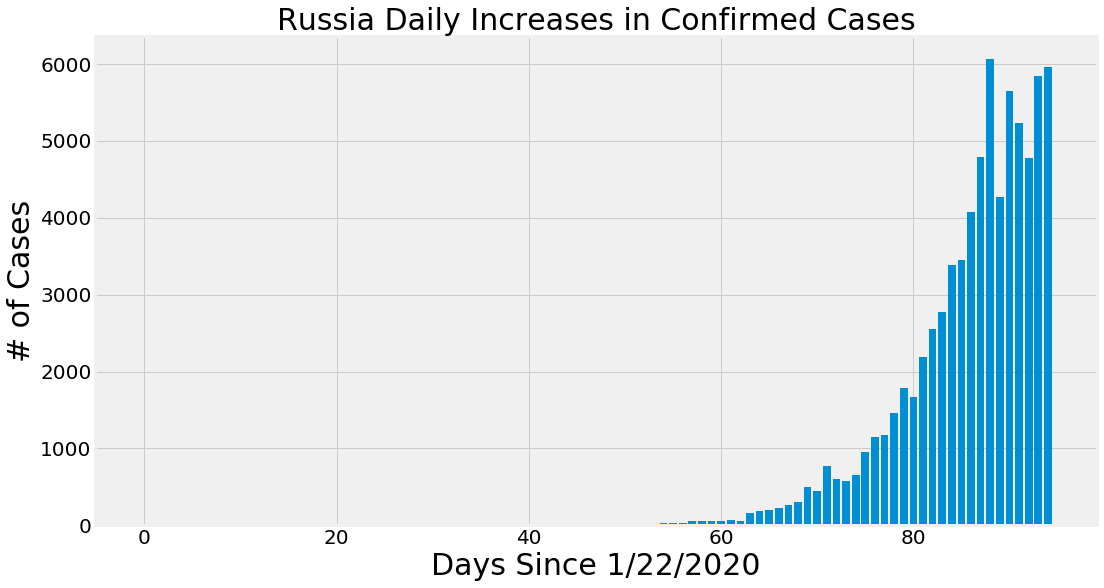

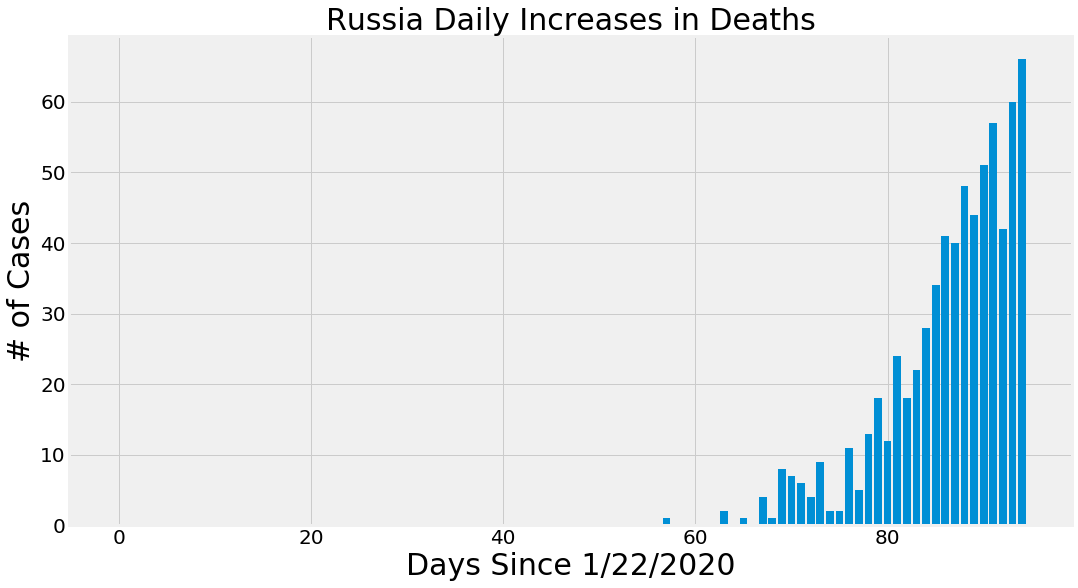

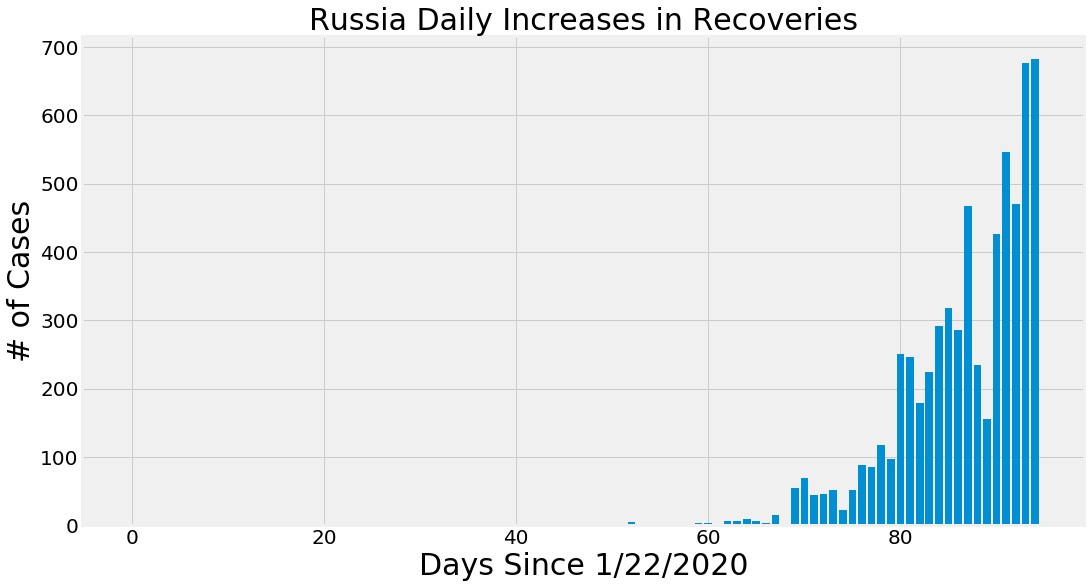

In [37]:
country_plot(adjusted_dates, russia_cases, russia_daily_increase, russia_daily_death, russia_daily_recovery, 'Russia')

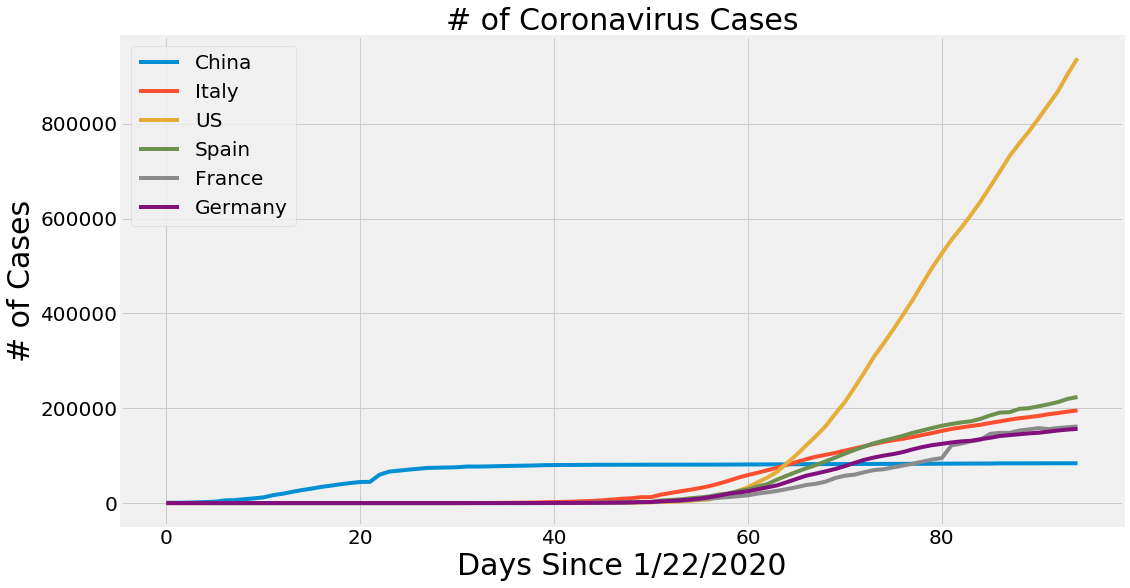

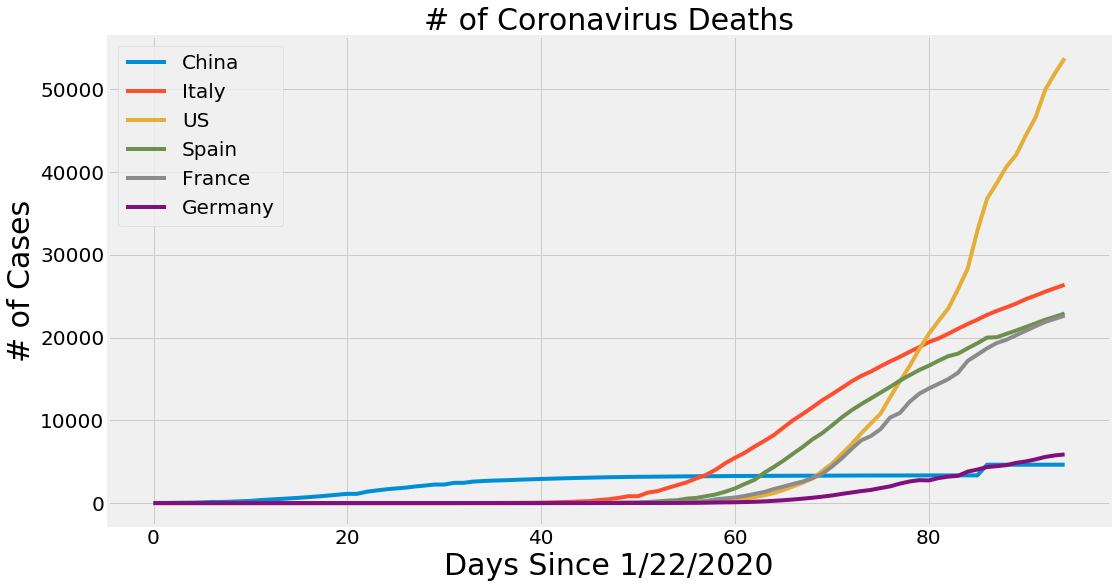

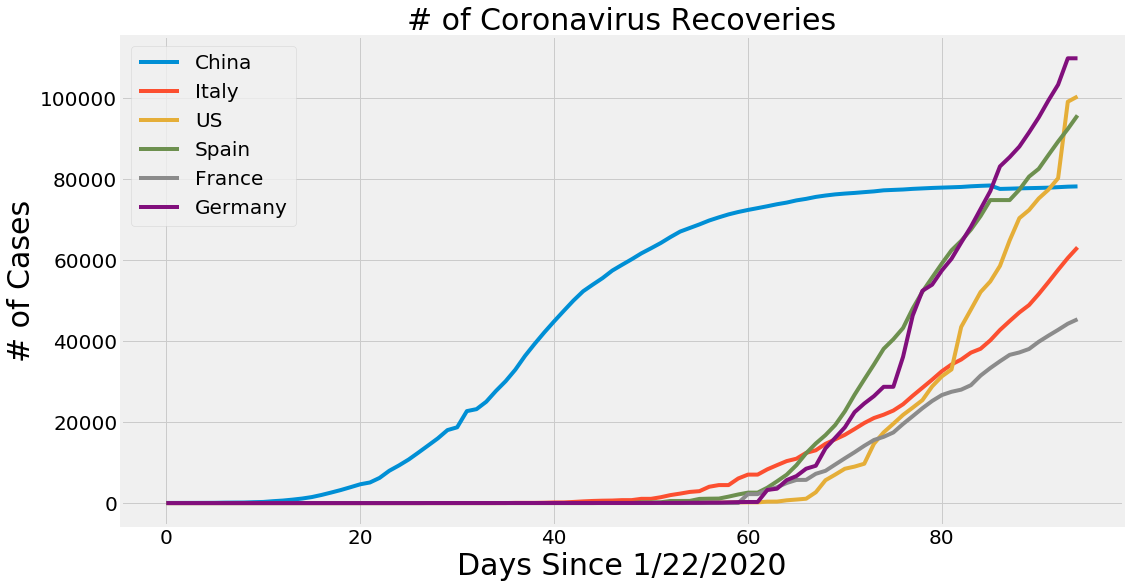

In [38]:
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, china_cases)
plt.plot(adjusted_dates, italy_cases)
plt.plot(adjusted_dates, us_cases)
plt.plot(adjusted_dates, spain_cases)
plt.plot(adjusted_dates, france_cases)
plt.plot(adjusted_dates, germany_cases)
plt.title('# of Coronavirus Cases', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['China', 'Italy', 'US', 'Spain', 'France', 'Germany'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, china_deaths)
plt.plot(adjusted_dates, italy_deaths)
plt.plot(adjusted_dates, us_deaths)
plt.plot(adjusted_dates, spain_deaths)
plt.plot(adjusted_dates, france_deaths)
plt.plot(adjusted_dates, germany_deaths)

plt.title('# of Coronavirus Deaths', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['China', 'Italy', 'US', 'Spain', 'France', 'Germany'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, china_recoveries)
plt.plot(adjusted_dates, italy_recoveries)
plt.plot(adjusted_dates, us_recoveries)
plt.plot(adjusted_dates, spain_recoveries)
plt.plot(adjusted_dates, france_recoveries)
plt.plot(adjusted_dates, germany_recoveries)
plt.title('# of Coronavirus Recoveries', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['China', 'Italy', 'US', 'Spain', 'France', 'Germany'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [39]:
def plot_predictions(x, y, pred, algo_name, color):
    plt.figure(figsize=(16, 9))
    plt.plot(x, y)
    plt.plot(future_forcast, pred, linestyle='dashed', color=color)
    plt.title('# of Coronavirus Cases Over Time', size=30)
    plt.xlabel('Days Since 1/22/2020', size=30)
    plt.ylabel('# of Cases', size=30)
    plt.legend(['Confirmed Cases', algo_name], prop={'size': 20})
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()

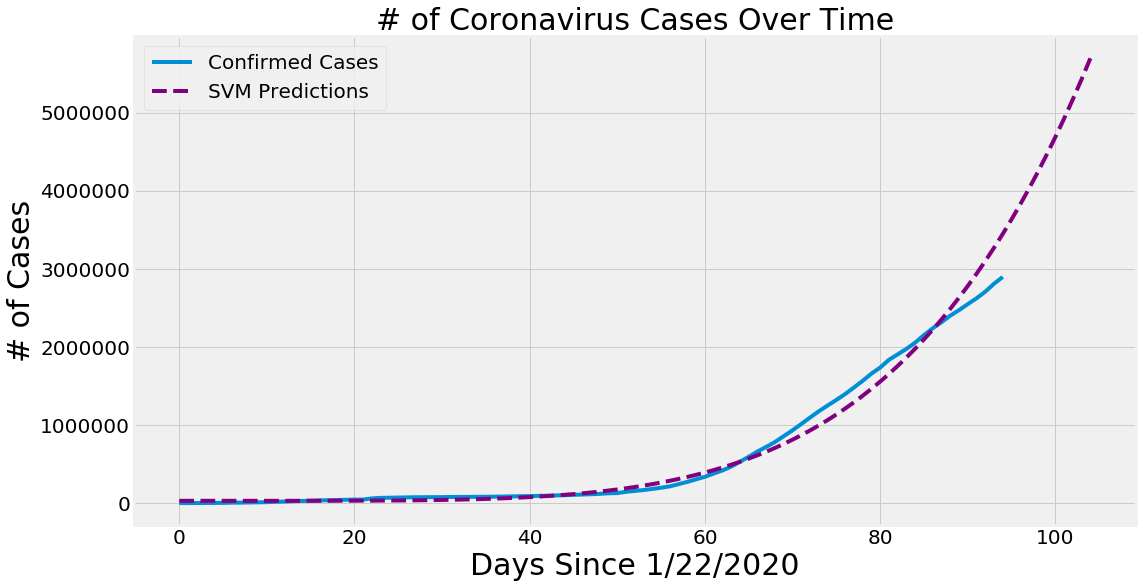

In [40]:
plot_predictions(adjusted_dates, world_cases, svm_pred, 'SVM Predictions', 'purple')

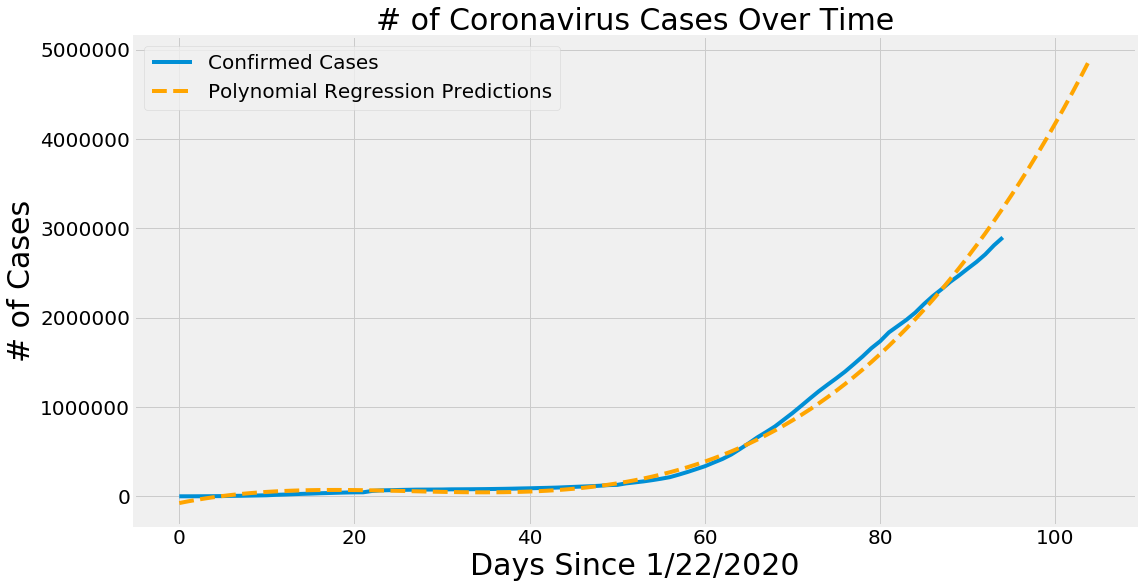

In [41]:
plot_predictions(adjusted_dates, world_cases, linear_pred, 'Polynomial Regression Predictions', 'orange')

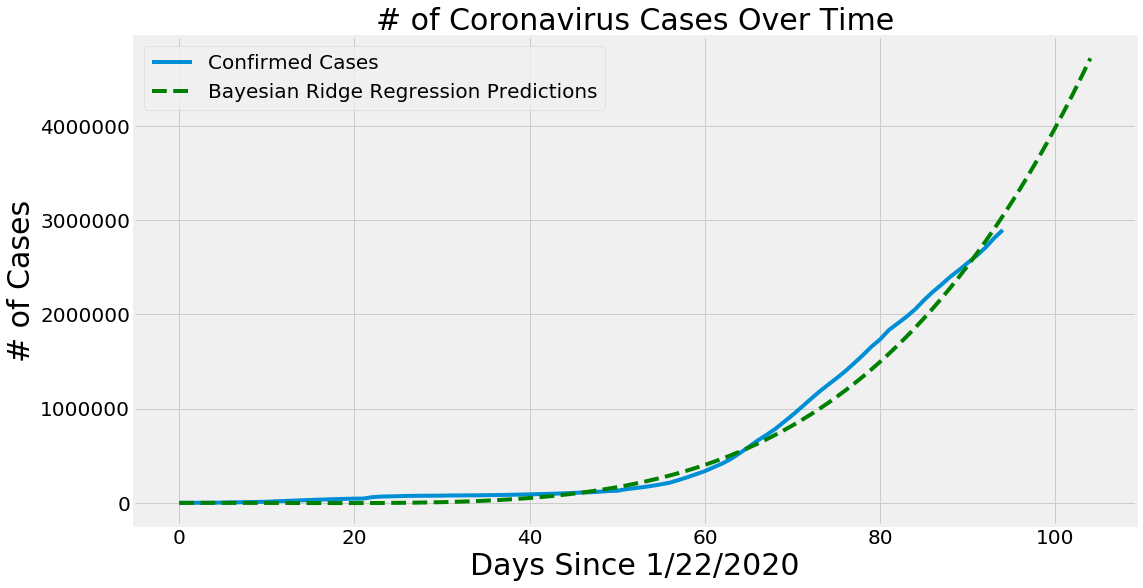

In [42]:
plot_predictions(adjusted_dates, world_cases, bayesian_pred, 'Bayesian Ridge Regression Predictions', 'green')

In [43]:
# Future predictions using SVM 
svm_df = pd.DataFrame({'Date': future_forcast_dates[-10:], 'SVM Predicted # of Confirmed Cases Worldwide': np.round(svm_pred[-10:])})
svm_df

,Date,SVM Predicted # of Confirmed Cases Worldwide
0,04/26/2020,3633946.0
1,04/27/2020,3827695.0
2,04/28/2020,4029688.0
3,04/29/2020,4240183.0
4,04/30/2020,4459448.0
5,05/01/2020,4687754.0
6,05/02/2020,4925377.0
7,05/03/2020,5172599.0
8,05/04/2020,5429708.0
9,05/05/2020,5696999.0


In [44]:
# Future predictions using polynomial regression
linear_pred = linear_pred.reshape(1,-1)[0]
svm_df = pd.DataFrame({'Date': future_forcast_dates[-10:], 'Polynomial Predicted # of Confirmed Cases Worldwide': np.round(linear_pred[-10:])})
svm_df

,Date,Polynomial Predicted # of Confirmed Cases Worldwide
0,04/26/2020,3371236.0
1,04/27/2020,3522784.0
2,04/28/2020,3678812.0
3,04/29/2020,3839382.0
4,04/30/2020,4004561.0
5,05/01/2020,4174412.0
6,05/02/2020,4348999.0
7,05/03/2020,4528386.0
8,05/04/2020,4712639.0
9,05/05/2020,4901820.0


In [45]:
# Future predictions using Bayesian Ridge 
svm_df = pd.DataFrame({'Date': future_forcast_dates[-10:], 'Bayesian Ridge Predicted # of Confirmed Cases Worldwide': np.round(bayesian_pred[-10:])})
svm_df

,Date,Bayesian Ridge Predicted # of Confirmed Cases Worldwide
0,04/26/2020,3189064.0
1,04/27/2020,3337656.0
2,04/28/2020,3491346.0
3,04/29/2020,3650251.0
4,04/30/2020,3814487.0
5,05/01/2020,3984169.0
6,05/02/2020,4159418.0
7,05/03/2020,4340352.0
8,05/04/2020,4527094.0
9,05/05/2020,4719764.0


Mortality Rate (worldwide) **susceptible to change **

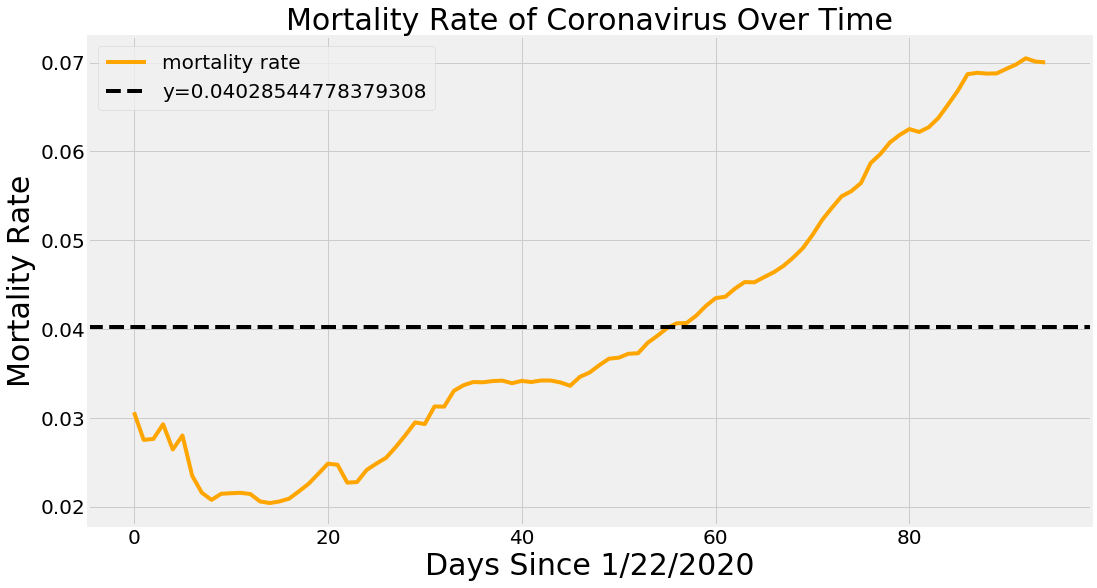

In [46]:
mean_mortality_rate = np.mean(mortality_rate)
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, mortality_rate, color='orange')
plt.axhline(y = mean_mortality_rate,linestyle='--', color='black')
plt.title('Mortality Rate of Coronavirus Over Time', size=30)
plt.legend(['mortality rate', 'y='+str(mean_mortality_rate)], prop={'size': 20})
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('Mortality Rate', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

Recovery Rate (worldwide) **suceptible to change **

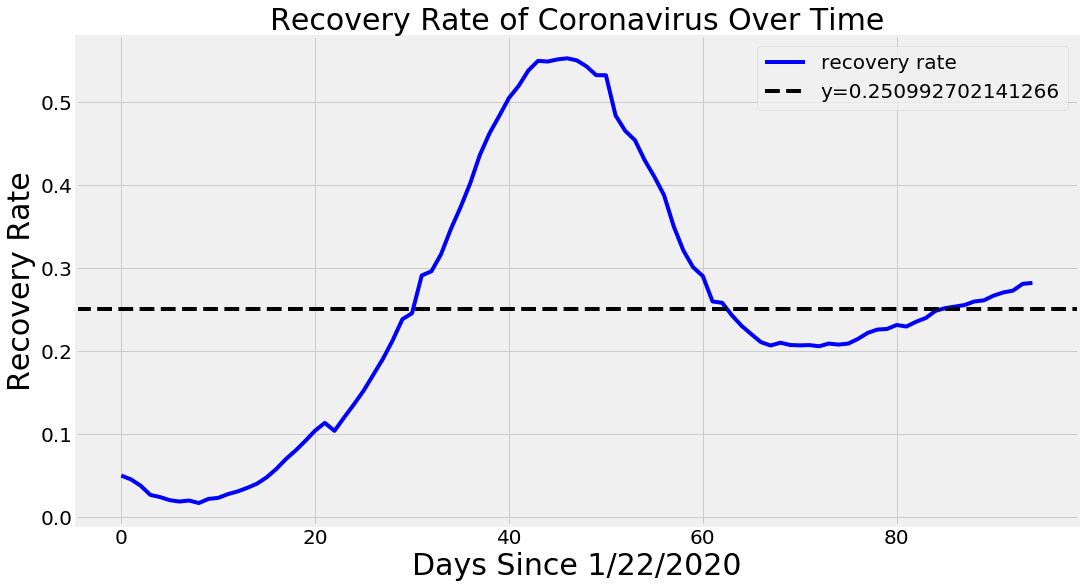

In [47]:
mean_recovery_rate = np.mean(recovery_rate)
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, recovery_rate, color='blue')
plt.axhline(y = mean_recovery_rate,linestyle='--', color='black')
plt.title('Recovery Rate of Coronavirus Over Time', size=30)
plt.legend(['recovery rate', 'y='+str(mean_recovery_rate)], prop={'size': 20})
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('Recovery Rate', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

Graphing deaths against recoveries

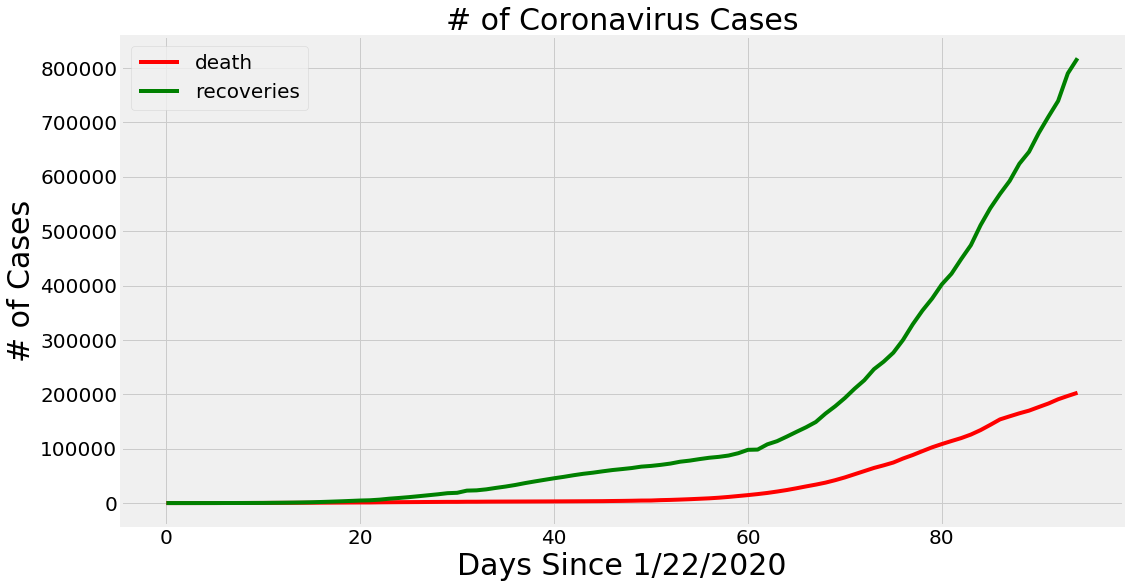

In [48]:
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, total_deaths, color='r')
plt.plot(adjusted_dates, total_recovered, color='green')
plt.legend(['death', 'recoveries'], loc='best', fontsize=20)
plt.title('# of Coronavirus Cases', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

Plotting the number of deaths against the number of recoveries

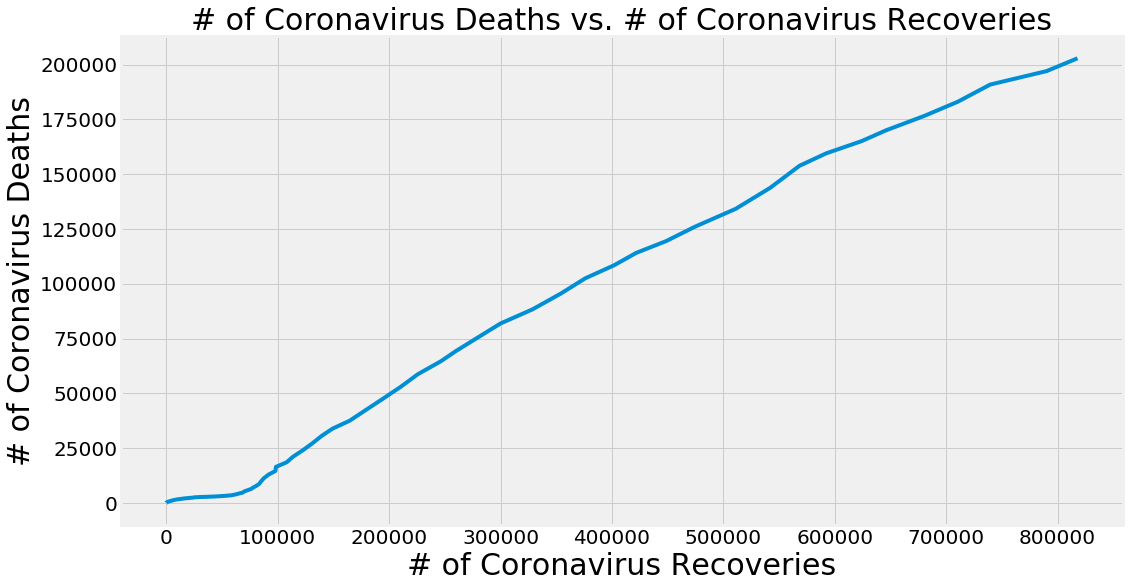

In [49]:
plt.figure(figsize=(16, 9))
plt.plot(total_recovered, total_deaths)
plt.title('# of Coronavirus Deaths vs. # of Coronavirus Recoveries', size=30)
plt.xlabel('# of Coronavirus Recoveries', size=30)
plt.ylabel('# of Coronavirus Deaths', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

Getting information about countries/regions that have confirmed coronavirus cases

In [50]:
unique_countries =  list(latest_data['Country_Region'].unique())

In [51]:
country_confirmed_cases = []
country_death_cases = [] 
country_active_cases = []
country_recovery_cases = []
country_mortality_rate = [] 

no_cases = []
for i in unique_countries:
    cases = latest_data[latest_data['Country_Region']==i]['Confirmed'].sum()
    if cases > 0:
        country_confirmed_cases.append(cases)
    else:
        no_cases.append(i)
        
for i in no_cases:
    unique_countries.remove(i)
    
# sort countries by the number of confirmed cases
unique_countries = [k for k, v in sorted(zip(unique_countries, country_confirmed_cases), key=operator.itemgetter(1), reverse=True)]
for i in range(len(unique_countries)):
    country_confirmed_cases[i] = latest_data[latest_data['Country_Region']==unique_countries[i]]['Confirmed'].sum()
    country_death_cases.append(latest_data[latest_data['Country_Region']==unique_countries[i]]['Deaths'].sum())
    country_recovery_cases.append(latest_data[latest_data['Country_Region']==unique_countries[i]]['Recovered'].sum())
    country_active_cases.append(country_confirmed_cases[i] - country_death_cases[i] - country_recovery_cases[i])
    country_mortality_rate.append(country_death_cases[i]/country_confirmed_cases[i])

In [52]:
country_df = pd.DataFrame({'Country Name': unique_countries, 'Number of Confirmed Cases': country_confirmed_cases,
                          'Number of Deaths': country_death_cases, 'Number of Recoveries' : country_recovery_cases, 
                          'Number of Active Cases' : country_active_cases,
                          'Mortality Rate': country_mortality_rate})
# number of cases per country/region

country_df.style.background_gradient(cmap='Greens')

,Country Name,Number of Confirmed Cases,Number of Deaths,Number of Recoveries,Number of Active Cases,Mortality Rate
0,US,938154,53755,100372,784027,0.0572987
1,Spain,223759,22902,95708,105149,0.102351
2,Italy,195351,26384,63120,105847,0.135059
3,France,161644,22648,45372,93624,0.14011
4,Germany,156513,5877,109800,40836,0.0375496
5,United Kingdom,149569,20381,774,128414,0.136265
6,Turkey,107773,2706,25582,79485,0.0251083
7,Iran,89328,5650,68193,15485,0.06325
8,China,83909,4636,78175,1098,0.0552503
9,Russia,74588,681,6250,67657,0.00913015


In [53]:
unique_provinces =  list(latest_data['Province_State'].unique())

Getting the latest information about provinces/states that have confirmed coronavirus cases

In [54]:
province_confirmed_cases = []
province_country = [] 
province_death_cases = [] 
province_recovery_cases = []
province_mortality_rate = [] 

no_cases = [] 
for i in unique_provinces:
    cases = latest_data[latest_data['Province_State']==i]['Confirmed'].sum()
    if cases > 0:
        province_confirmed_cases.append(cases)
    else:
        no_cases.append(i)
 
# remove areas with no confirmed cases
for i in no_cases:
    unique_provinces.remove(i)
    
unique_provinces = [k for k, v in sorted(zip(unique_provinces, province_confirmed_cases), key=operator.itemgetter(1), reverse=True)]
for i in range(len(unique_provinces)):
    province_confirmed_cases[i] = latest_data[latest_data['Province_State']==unique_provinces[i]]['Confirmed'].sum()
    province_country.append(latest_data[latest_data['Province_State']==unique_provinces[i]]['Country_Region'].unique()[0])
    province_death_cases.append(latest_data[latest_data['Province_State']==unique_provinces[i]]['Deaths'].sum())
    province_recovery_cases.append(latest_data[latest_data['Province_State']==unique_provinces[i]]['Recovered'].sum())
    province_mortality_rate.append(province_death_cases[i]/province_confirmed_cases[i])

In [55]:
# number of cases per province/state/city
province_df = pd.DataFrame({'Province/State Name': unique_provinces, 'Country': province_country, 'Number of Confirmed Cases': province_confirmed_cases,
                          'Number of Deaths': province_death_cases, 'Number of Recoveries' : province_recovery_cases,
                          'Mortality Rate': province_mortality_rate})
# number of cases per country/region

province_df.style.background_gradient(cmap='Greens')

,Province/State Name,Country,Number of Confirmed Cases,Number of Deaths,Number of Recoveries,Mortality Rate
0,New York,US,282143,22009,0,0.0780065
1,New Jersey,US,105498,5914,0,0.0560579
2,Hubei,China,68128,4512,63604,0.0662283
3,Massachusetts,US,53348,2730,0,0.0511734
4,California,US,42368,1689,0,0.039865
5,Illinois,US,41777,1875,0,0.0448812
6,Pennsylvania,US,41153,1793,0,0.0435691
7,Michigan,US,37074,3155,0,0.0851001
8,Florida,US,30839,1055,0,0.0342099
9,Louisiana,US,26512,1707,0,0.0643859


In [56]:
nan_indices = [] 

# handle nan if there is any, it is usually a float: float('nan')

for i in range(len(unique_provinces)):
    if type(unique_provinces[i]) == float:
        nan_indices.append(i)

unique_provinces = list(unique_provinces)
province_confirmed_cases = list(province_confirmed_cases)

for i in nan_indices:
    unique_provinces.pop(i)
    province_confirmed_cases.pop(i)

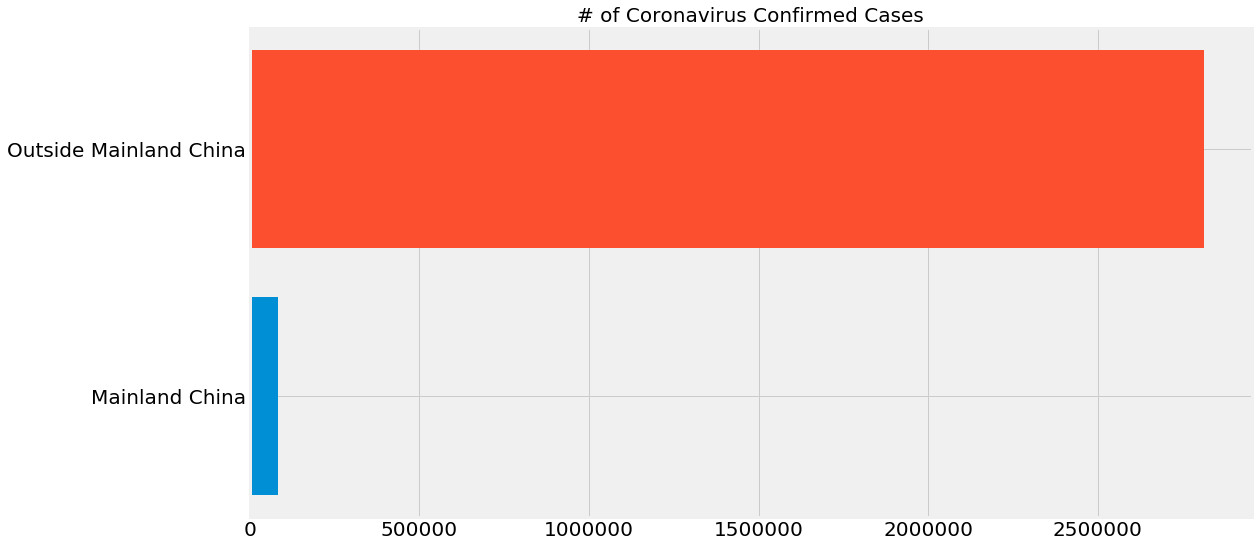

In [57]:
china_confirmed = latest_data[latest_data['Country_Region']=='China']['Confirmed'].sum()
outside_mainland_china_confirmed = np.sum(country_confirmed_cases) - china_confirmed
plt.figure(figsize=(16, 9))
plt.barh('Mainland China', china_confirmed)
plt.barh('Outside Mainland China', outside_mainland_china_confirmed)
plt.title('# of Coronavirus Confirmed Cases', size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [58]:
print('Outside Mainland China {} cases:'.format(outside_mainland_china_confirmed))
print('Mainland China: {} cases'.format(china_confirmed))
print('Total: {} cases'.format(china_confirmed+outside_mainland_china_confirmed))

Outside Mainland China 2812837 cases:
Mainland China: 83909 cases
Total: 2896746 cases


In [59]:
# Only show 10 countries with the most confirmed cases, the rest are grouped into the other category
visual_unique_countries = [] 
visual_confirmed_cases = []
others = np.sum(country_confirmed_cases[10:])

for i in range(len(country_confirmed_cases[:10])):
    visual_unique_countries.append(unique_countries[i])
    visual_confirmed_cases.append(country_confirmed_cases[i])
    
visual_unique_countries.append('Others')
visual_confirmed_cases.append(others)

***Visual Representations*** (bar charts and pie charts)

In [60]:
def plot_bar_graphs(x, y, title):
    plt.figure(figsize=(16, 9))
    plt.barh(x, y)
    plt.title(title, size=20)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()

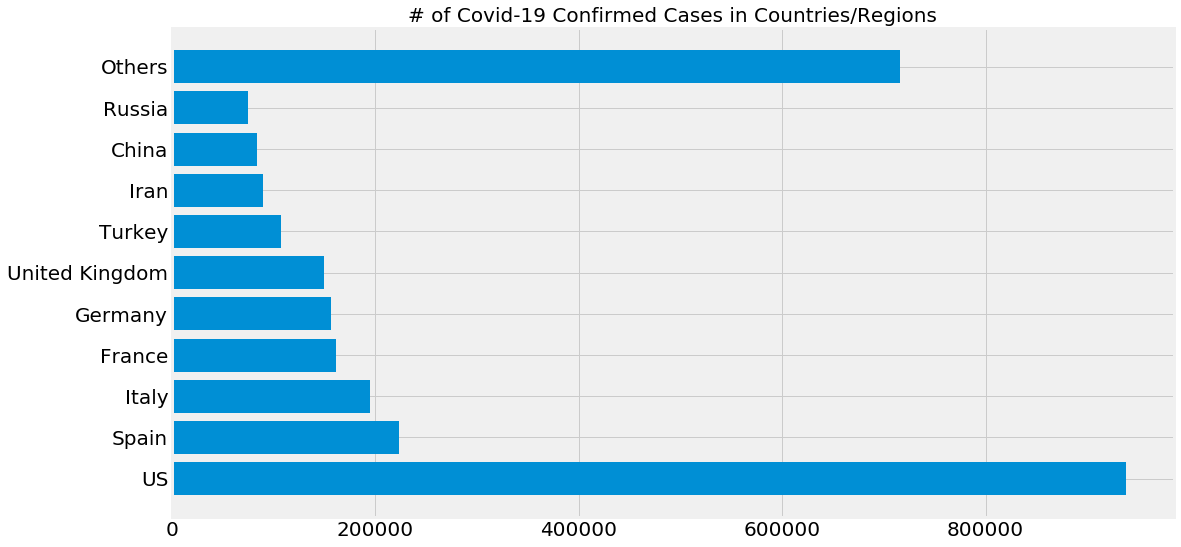

In [61]:
plot_bar_graphs(visual_unique_countries, visual_confirmed_cases, '# of Covid-19 Confirmed Cases in Countries/Regions')

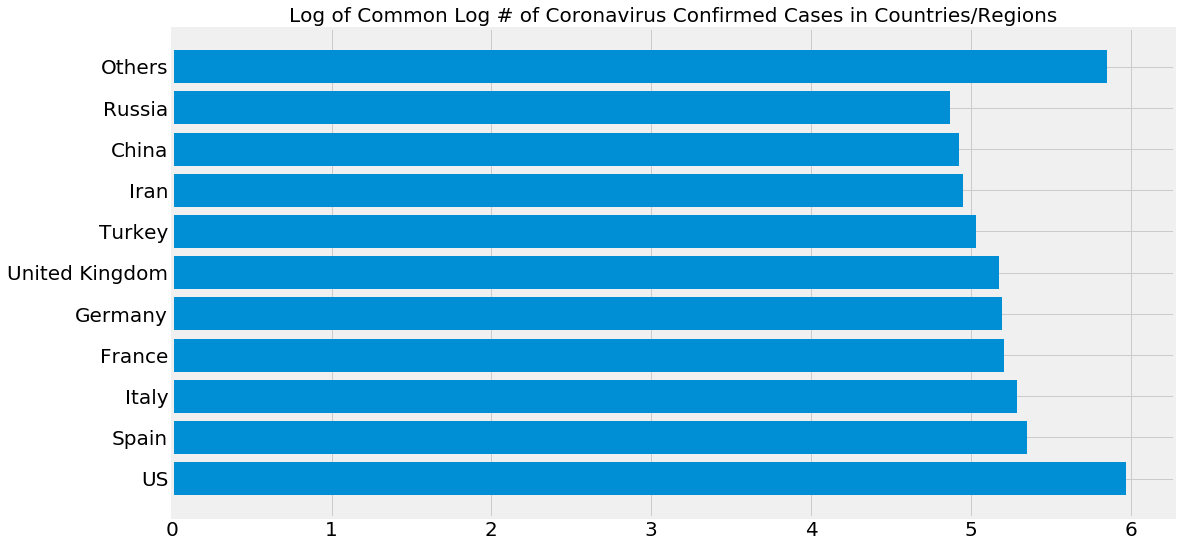

In [62]:
log_country_confirmed_cases = [math.log10(i) for i in visual_confirmed_cases]
plot_bar_graphs(visual_unique_countries, log_country_confirmed_cases, 'Log of Common Log # of Coronavirus Confirmed Cases in Countries/Regions')

In [63]:
# Only show 10 provinces with the most confirmed cases, the rest are grouped into the other category
visual_unique_provinces = [] 
visual_confirmed_cases2 = []
others = np.sum(province_confirmed_cases[10:])
for i in range(len(province_confirmed_cases[:10])):
    visual_unique_provinces.append(unique_provinces[i])
    visual_confirmed_cases2.append(province_confirmed_cases[i])

visual_unique_provinces.append('Others')
visual_confirmed_cases2.append(others)

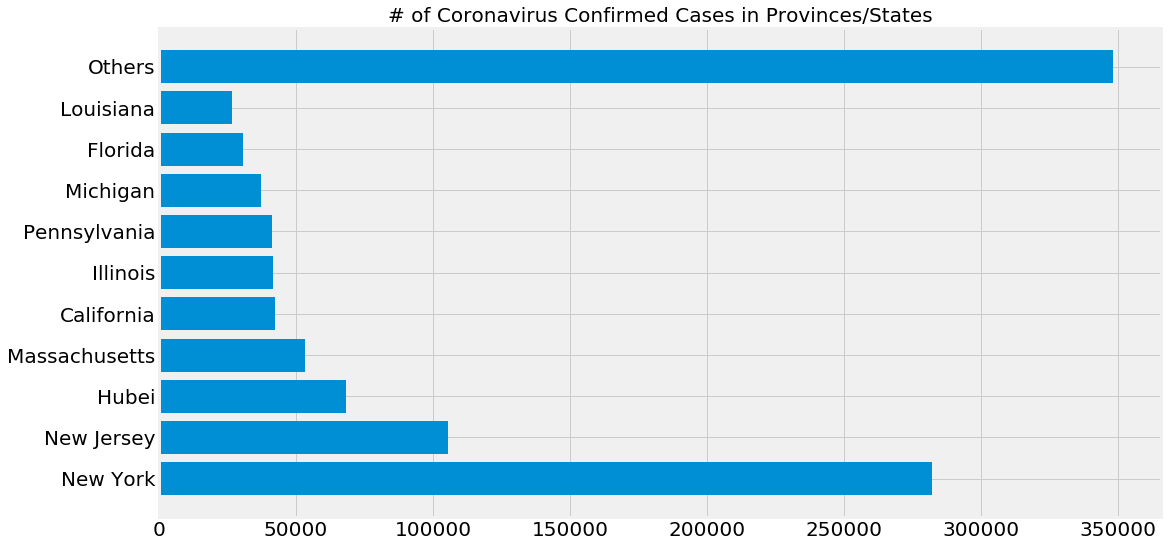

In [64]:
plot_bar_graphs(visual_unique_provinces, visual_confirmed_cases2, '# of Coronavirus Confirmed Cases in Provinces/States')

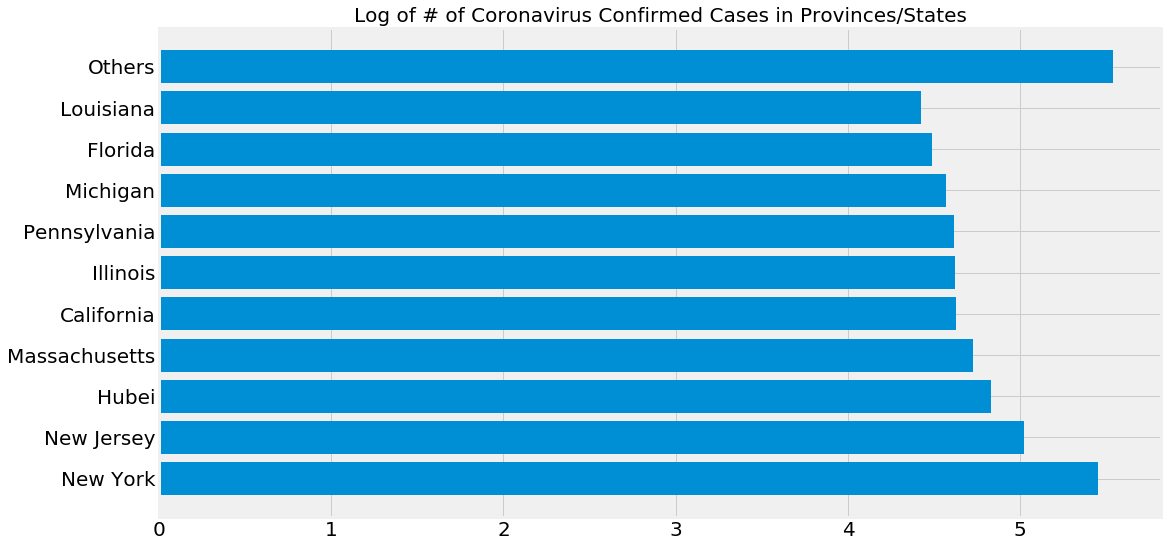

In [65]:
log_province_confirmed_cases = [math.log10(i) for i in visual_confirmed_cases2]
plot_bar_graphs(visual_unique_provinces, log_province_confirmed_cases, 'Log of # of Coronavirus Confirmed Cases in Provinces/States')

In [66]:
def plot_pie_charts(x, y, title):
    c = random.choices(list(mcolors.CSS4_COLORS.values()),k = len(unique_countries))
    plt.figure(figsize=(20,15))
    plt.title(title, size=20)
    plt.pie(y, colors=c)
    plt.legend(x, loc='best', fontsize=15)
    plt.show()

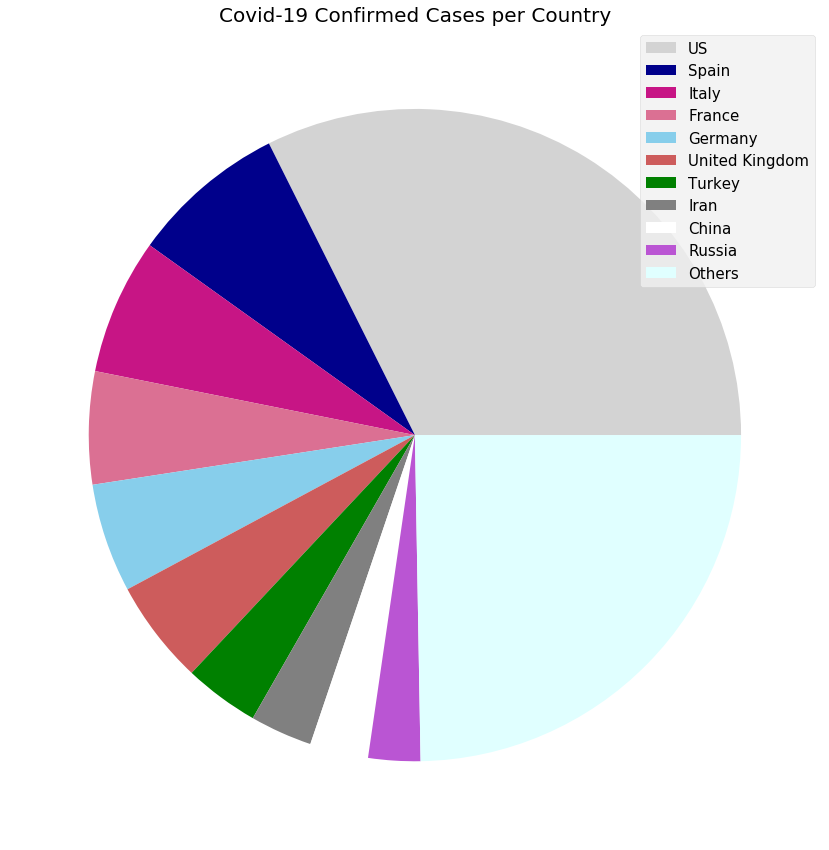

In [67]:
plot_pie_charts(visual_unique_countries, visual_confirmed_cases, 'Covid-19 Confirmed Cases per Country')

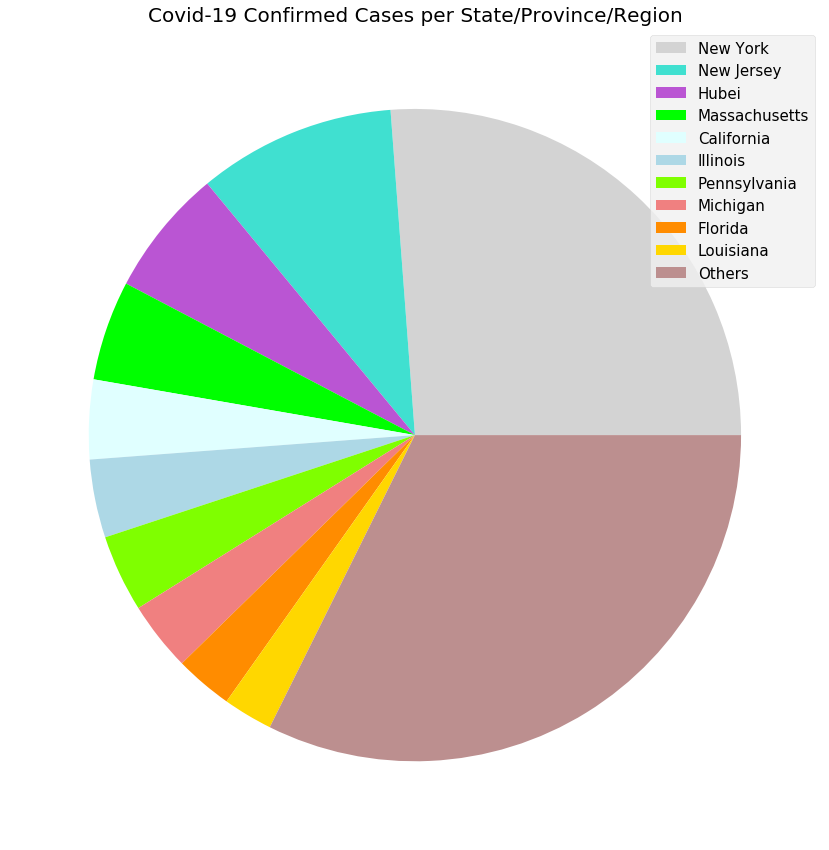

In [68]:
plot_pie_charts(visual_unique_provinces, visual_confirmed_cases2, 'Covid-19 Confirmed Cases per State/Province/Region')

In [69]:
# Plotting countries with regional data using a pie chart 

def plot_pie_country_with_regions(country_name, title):
    regions = list(latest_data[latest_data['Country_Region']==country_name]['Province_State'].unique())
    confirmed_cases = []
    no_cases = [] 
    for i in regions:
        cases = latest_data[latest_data['Province_State']==i]['Confirmed'].sum()
        if cases > 0:
            confirmed_cases.append(cases)
        else:
            no_cases.append(i)

    # remove areas with no confirmed cases
    for i in no_cases:
        regions.remove(i)

    # only show the top 5 states
    regions = [k for k, v in sorted(zip(regions, confirmed_cases), key=operator.itemgetter(1), reverse=True)]

    for i in range(len(regions)):
        confirmed_cases[i] = latest_data[latest_data['Province_State']==regions[i]]['Confirmed'].sum()  
    
    # additional province/state will be considered "others"
    
    if(len(regions)>5):
        regions_5 = regions[:5]
        regions_5.append('Others')
        confirmed_cases_5 = confirmed_cases[:5]
        confirmed_cases_5.append(np.sum(confirmed_cases[5:]))
        plot_pie_charts(regions_5,confirmed_cases_5, title)
    else:
        plot_pie_charts(regions,confirmed_cases, title)

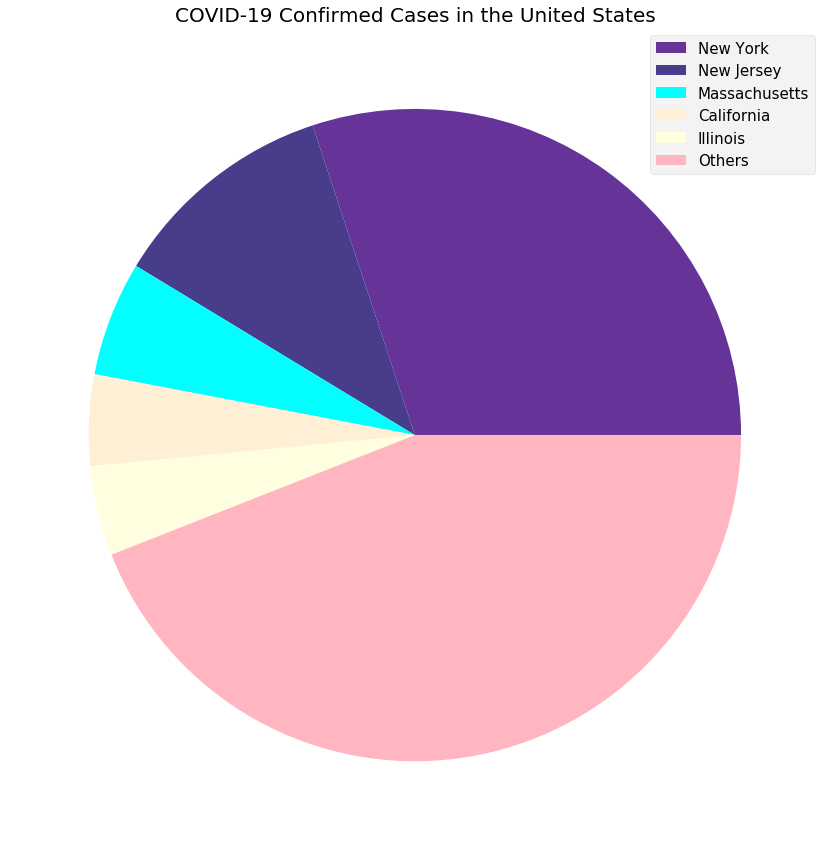

In [70]:
plot_pie_country_with_regions('US', 'COVID-19 Confirmed Cases in the United States')

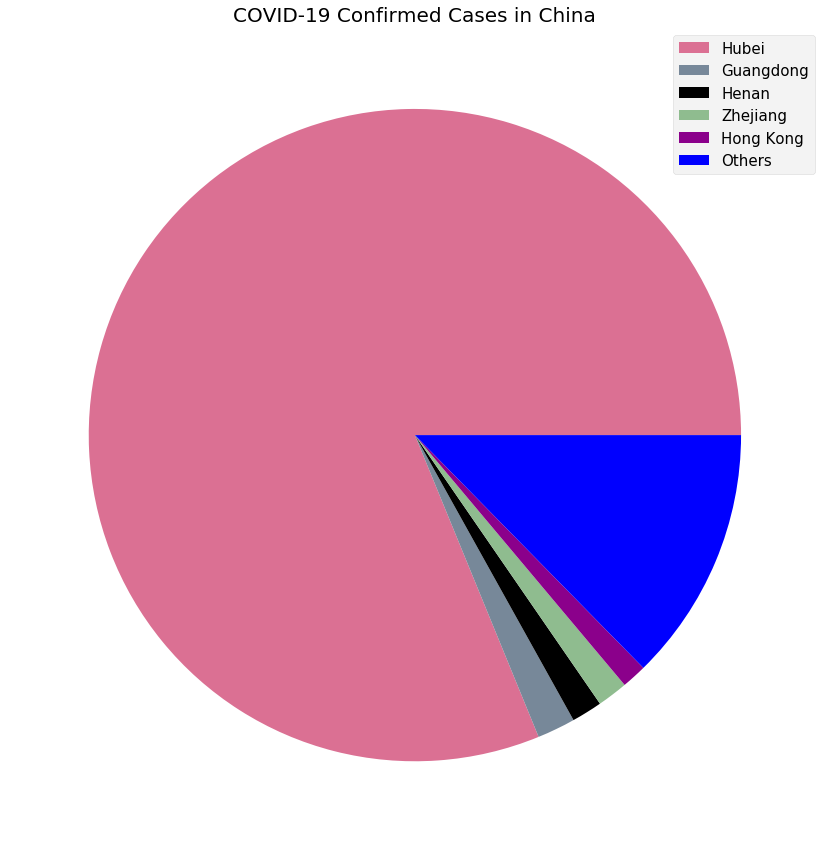

In [71]:
plot_pie_country_with_regions('China', 'COVID-19 Confirmed Cases in China')

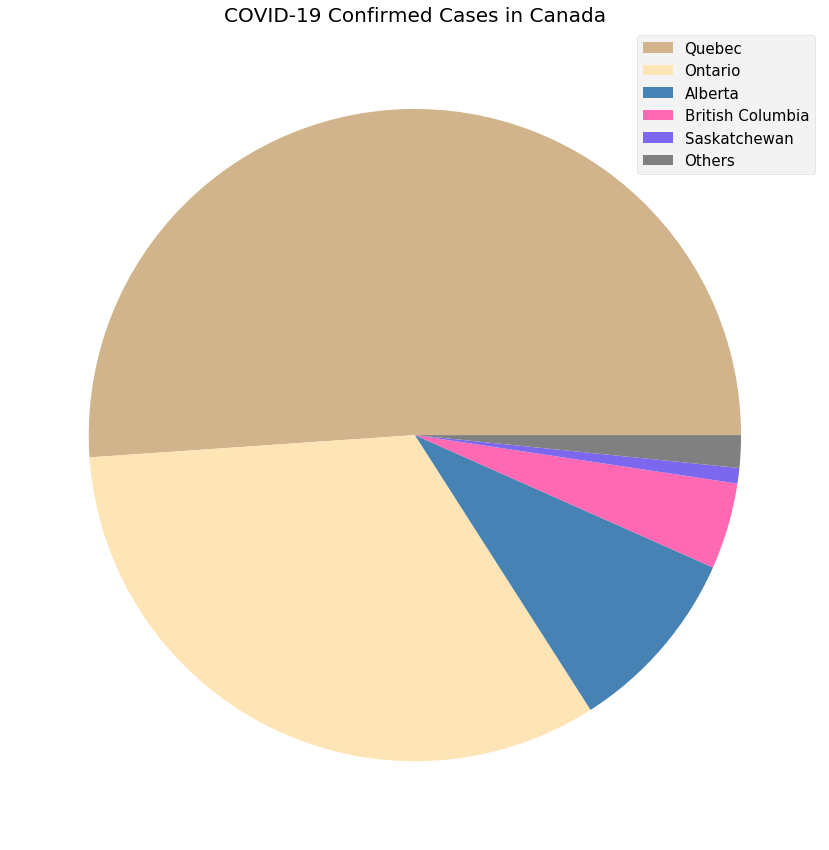

In [72]:
plot_pie_country_with_regions('Canada', 'COVID-19 Confirmed Cases in Canada')

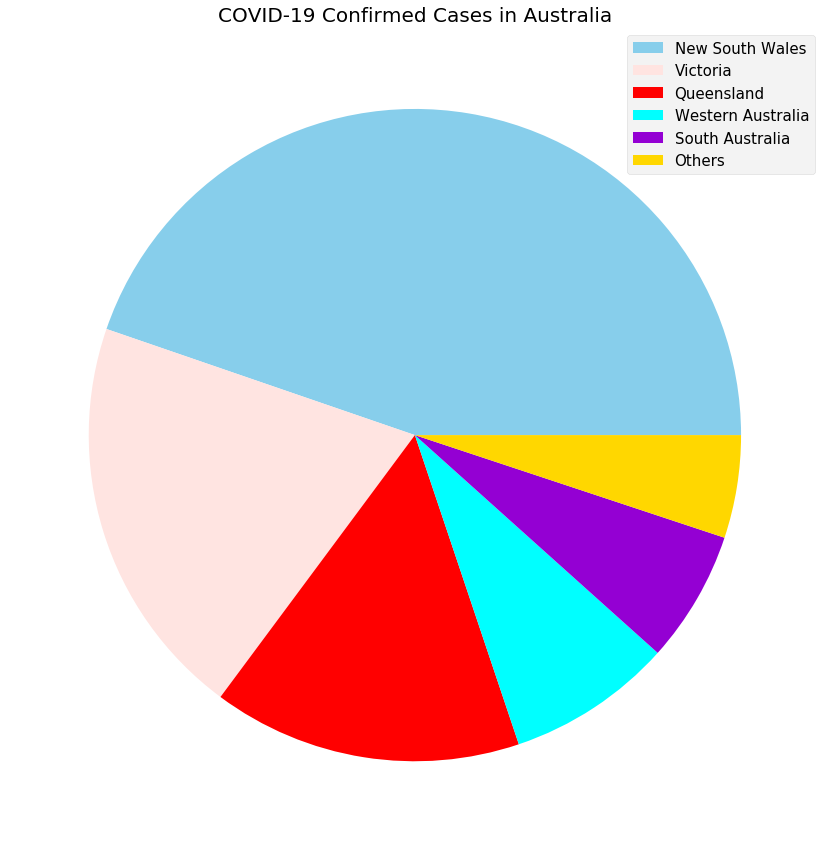

In [73]:
plot_pie_country_with_regions('Australia', 'COVID-19 Confirmed Cases in Australia')

US Medical Data on Testing and Hosptialization

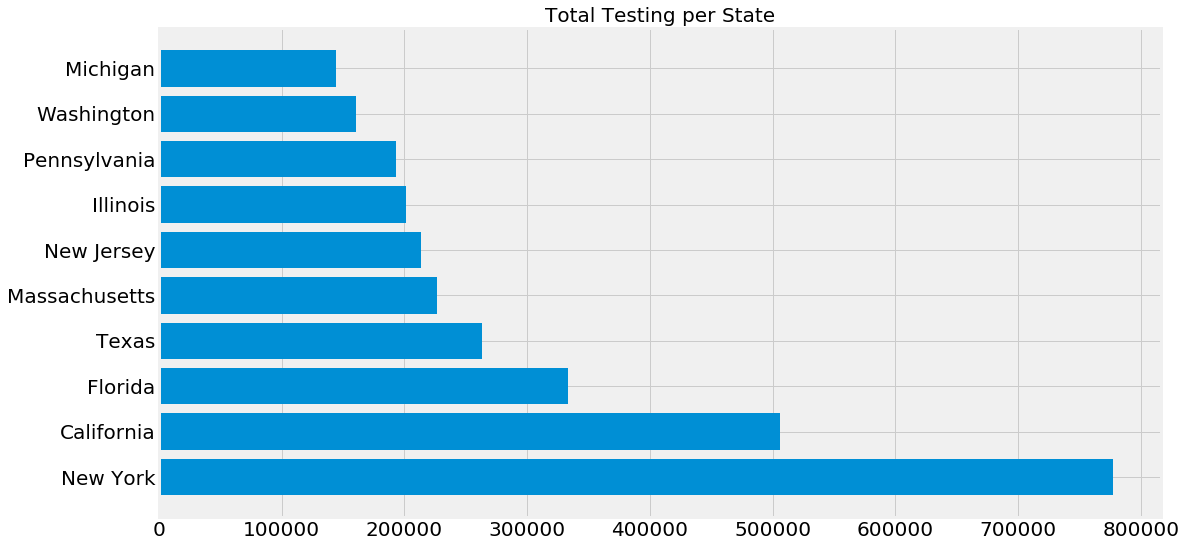

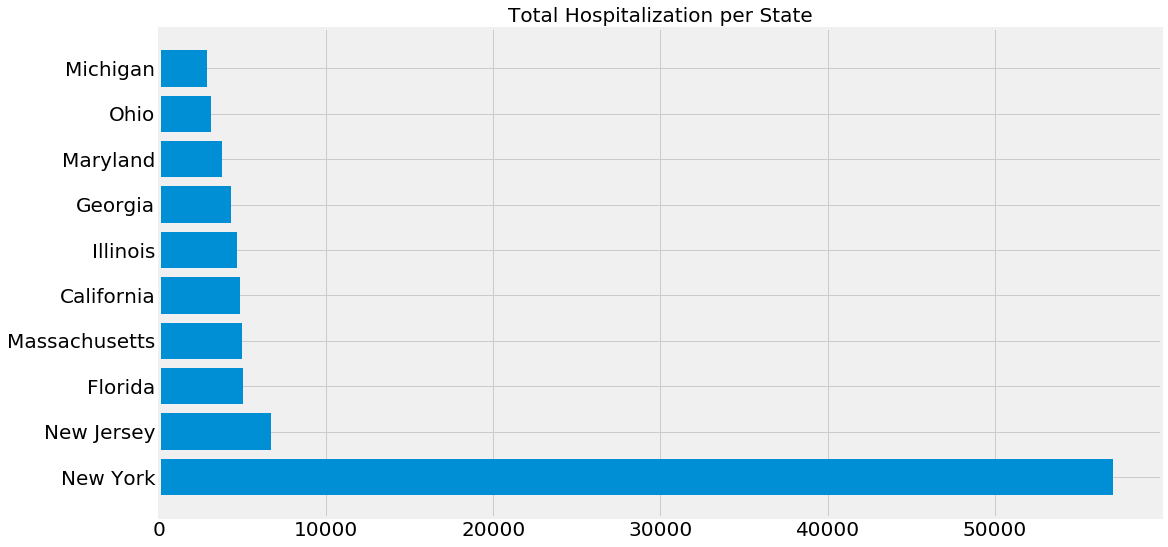

In [74]:
# Replace nan with 0
us_medical_data.fillna(value=0, inplace=True)

def plot_us_medical_data():
    states = us_medical_data['Province_State'].unique()
    testing_number = []
    hospitalization_number = [] 

    for i in states:
        testing_number.append(us_medical_data[us_medical_data['Province_State']==i]['People_Tested'].sum())
        hospitalization_number.append(us_medical_data[us_medical_data['Province_State']==i]['People_Hospitalized'].sum())
    
    # only show the top 10 states
    testing_states = [k for k, v in sorted(zip(states, testing_number), key=operator.itemgetter(1), reverse=True)]
    hospitalization_states = [k for k, v in sorted(zip(states, hospitalization_number), key=operator.itemgetter(1), reverse=True)]
    
    for i in range(len(states)):
        testing_number[i] = us_medical_data[us_medical_data['Province_State']==testing_states[i]]['People_Tested'].sum()
        hospitalization_number[i] = us_medical_data[us_medical_data['Province_State']==hospitalization_states[i]]['People_Hospitalized'].sum()
    
    plot_bar_graphs(testing_states[:10], testing_number[:10], 'Total Testing per State')
    plot_bar_graphs(hospitalization_states[:10], hospitalization_number[:10], 'Total Hospitalization per State')
    
plot_us_medical_data()